# #winerec - A Wine Recommendation System

This notebook presents the code necessary to build the content-based wine recommendation system. Its purpose is to show the process, explain and document the decisions taken and demonstrate the sytem.   

More explanations and comments are found in [the presentation of the project](https://docs.google.com/presentation/d/1tCcIGw24lLizHxUUMnMihTvOzKZYvRUpyS5TRDJtqBU/edit?usp=sharing).

## Organization of the Notebook

The organization of the notebook follows the different steps undertaken to create the recommendation system:

1. Data Exploration: source of the data, the different variables and exploratory plots
2. Data Processing:
    1. Data selection, filtering and handling of missing values
    2. Tokenization and cleaning of the text descriptions
3. Deeper Data Understanding (after processing and cleaning)
    1. Bivariate Data Exploration
4. Testing Different Recommendation Systems
    1. BoW + cosine similarity
    2. tf-idf + cosine similarity
    3. tf-idf bigrams + cosine similarity
    4. pre-trained word2vec + cosine similarity
    5. custom word2vec + cosine similarity
    6. LDA topic model + cosine similarity
5. Evaluation of recommender systems
6. Conclusion

In [1]:
# IMPORTING THE NECESSARY PACKAGES AND FUNCTIONS:

# generic:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import time 

# more specific:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer # Normalize samples individually to unit norm.
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler # used to compute stacked percentages barplots
from sklearn.cluster import MeanShift, DBSCAN, KMeans # used for evaluating the recommenders
from sklearn.metrics import confusion_matrix

import pickle # to save models, for instance LDA outputs
from IPython.display import Image # to load and display an image in a code chunk
import itertools # used for instance to flatten list of lists

# NLP:
import spacy # version 2.2.1 
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import word2vec
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud
from sklearn.decomposition import TruncatedSVD # LSA
from sklearn.decomposition import NMF # NMF
from sklearn.decomposition import LatentDirichletAllocation # LDA
import pyLDAvis # used to visualize and plot ouptut of LDA
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()


In [2]:
# some general preferences, definitions:

mycolor = "steelblue" # change the color of the one-color plots

## 1. Data Exploration

The [dataset](https://www.kaggle.com/zynicide/wine-reviews) was uploaded on Kaggle by Zack Thout. It consists of 140’000 wine reviews scraped from the [WineEnthusiast](https://www.winemag.com/?s=&drink_type=wine) magazine website. I use a new version of the dataset, extracted on March 2019 (c.f. [discussion](https://www.kaggle.com/zynicide/wine-reviews/discussion/83970)) and found [here](https://www.kaggle.com/zynicide/wine-reviews/discussion/83970).  

We first explore the data. The observations will guide the next data processing steps.

In [3]:
# load data: 
raw_winedata = pd.read_csv("../data/winemag-data-190314.csv").drop("Unnamed: 0", axis=1) # indexes were stored as col
initial_number_of_rows = raw_winedata.shape[0]
print(raw_winedata.shape)
raw_winedata.head()

(141617, 14)


,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,vintage
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,2013.0
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,2011.0
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,2013.0
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013.0
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012.0


In [4]:
# variables types:
raw_winedata.dtypes

country                   object
description               object
designation               object
points                     int64
price                    float64
province                  object
region_1                  object
region_2                  object
taster_name               object
taster_twitter_handle     object
title                     object
variety                   object
winery                    object
vintage                  float64
dtype: object

In [5]:
# checking for missing values:
raw_winedata.isnull().sum()

country                     61
description                  0
designation              40182
points                       0
price                     9658
province                    61
region_1                 22886
region_2                 86832
taster_name              24917
taster_twitter_handle    30649
title                        0
variety                      1
winery                       0
vintage                   5234
dtype: int64

### Variables in the Dataset

|variable|short explanation|
|--------|-----------------|
|country|The country that the wine is from|
|description|Wine description by a _sommelier_, identified in the column "taster"|
|designation|The vineyard within the winery where the grapes that made the wine are from|
|points|The number of points WineEnthusiast rated the wine on a scale of 80-100 (wines deemed unacceptable (rating < 80) are not reviewed)|
|price|The cost for a bottle of the wine in USD |
|province|The province or state that the wine is from|
|region_1|The wine growing area in a province or state (e.g. Napa)|
|region_2|Sometimes there are more specific regions specified within a wine growing area (e.g. Rutherford inside the Napa Valley)|
|taster_name|Name of the _sommelier_ who wrote the description|
|taster_twitter_handle| |
|title|The title of the wine review|
|variety|The type of grapes used to make the wine (e.g. Pinot Noir)|
|winery|The winery that made the wine|
|vintage|Extracted from "title" when present|


### Univariate Distributions

We then have a look at the distribution of the most important variables.


#### Description

The variable that interest us the most is the variable _description_, as we will base our content-based recommendation system on it. There are no missing values, however some descriptions are duplicated:

In [6]:
# inspect duplicated description:
duplicates_description  = raw_winedata[raw_winedata.duplicated(subset='description', keep=False)].sort_values(by='description')
print('number of duplicated descriptions: ', duplicates_description.shape[0]/2)
# duplicates_description # if want to print duplicates

# note: there are no full duplicates of row:
# duplicates = raw_winedata[raw_winedata.duplicated()] # is empty

number of duplicated descriptions:  38.0


No rows are full duplicates. However, 38 descriptions occur twice. After inspection, usually the descriptions occuring twice are two different wines coming from the same region. Sometimes even from the same winery, but with a different designation (e.g. "reserve"). We cannot know if these duplicate descriptions are valid tasting description or copy-paste errors from the tasters. Thus, we could keep them and assume that the taster did voluntarily copy their description because the wine was indeed very similar. However we have to keep in mind that if two descriptions are exact copies, the similarity distance that we will compute, or tf-idf vectors or topics, or actually any measure will be the same.  

To stay on the safe side, we will remove these duplicates when processing data.

In [7]:
# Some examples of descriptions:
for i in range(1,5):
    print(raw_winedata.description[i], '\n')

This is ripe and fruity, a wine that is smooth while still structured. Firm tannins are filled out with juicy red berry fruits and freshened with acidity. It's  already drinkable, although it will certainly be better from 2016. 

Tart and snappy, the flavors of lime flesh and rind dominate. Some green pineapple pokes through, with crisp acidity underscoring the flavors. The wine was all stainless-steel fermented. 

Pineapple rind, lemon pith and orange blossom start off the aromas. The palate is a bit more opulent, with notes of honey-drizzled guava and mango giving way to a slightly astringent, semidry finish. 

Much like the regular bottling from 2012, this comes across as rather rough and tannic, with rustic, earthy, herbal characteristics. Nonetheless, if you think of it as a pleasantly unfussy country wine, it's a good companion to a hearty winter stew. 



Already with this very small subset, we note that not all words or sentences used are directly related to taste. For instance: "although it will certainly be better from 2016" or "Much like the regular bottling from 2012". 

Number of characters in the longest descritption:  829 ; and in the shortest:  20 . The mean is  242.97805348227968  and the median 237.0


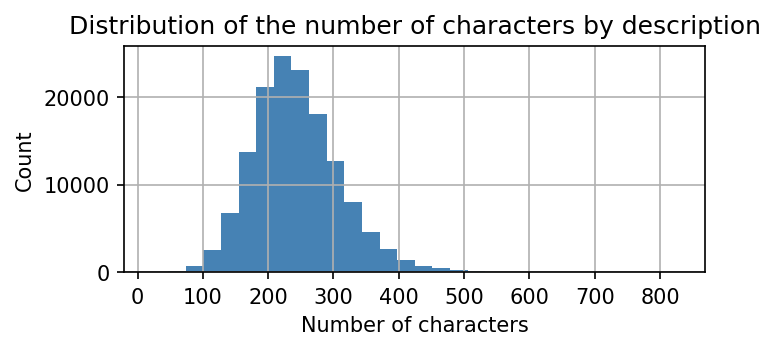

In [8]:
# length of the descriptions:
descr_lengths = raw_winedata.description.apply(len)
print("Number of characters in the longest descritption: ", max(descr_lengths), 
      '; and in the shortest: ', min(descr_lengths), '. The mean is ',
     np.mean(descr_lengths), ' and the median', np.median(descr_lengths))
# distribution: 
plt.figure(figsize=(5,2), dpi=150)
raw_winedata.description.apply(len).hist(bins=30, color=mycolor)
plt.xlabel('Number of characters')
plt.ylabel('Count')
plt.title('Distribution of the number of characters by description')
plt.savefig("../figures/hist_descr_length.png", bbox_inches='tight')
plt.show()

Some descriptions are really short. Do they still seem to carry enough relevant information for NLP?

In [9]:
# # Use this code to print the short descriptions
# short_descr = raw_winedata[raw_winedata.description.apply(len) < 45].description
# for descr in short_descr:
#     print(descr)

After visual inspection, we found that short descriptions usually still carry relevant information, thus we will only get rid of the descriptions that are under 45 characters long.  

We can quickly have a look at the most frequent words used:

In [10]:
def get_top_n_words(corpus, n=None):
    """
        List the top n words in a vocabulary according to occurrence in a text corpus.
    """
    # Tokenization
    # Note: we do not care here much about the details of the parameters,
    # we just want to have a look at the most common words: 
    vectorizer = CountVectorizer(analyzer='word',       
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             max_features=1000,             # max number of unique words
                            )
    vec = vectorizer.fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

print(get_top_n_words(raw_winedata['description'], 100))

[('wine', 88822), ('flavors', 68104), ('fruit', 54225), ('palate', 45084), ('aromas', 45055), ('acidity', 39090), ('finish', 38132), ('tannins', 35255), ('drink', 34930), ('black', 32737), ('cherry', 32237), ('ripe', 30574), ('red', 24253), ('spice', 21223), ('notes', 20654), ('nose', 20166), ('oak', 19383), ('rich', 19284), ('fresh', 18996), ('berry', 18963), ('dry', 18143), ('plum', 16635), ('apple', 15162), ('fruits', 14888), ('white', 14585), ('soft', 14472), ('offers', 14298), ('light', 14253), ('blend', 14128), ('texture', 14034), ('blackberry', 13768), ('sweet', 13713), ('crisp', 13666), ('dark', 13604), ('bodied', 13356), ('citrus', 12873), ('bright', 12222), ('shows', 12119), ('vanilla', 11766), ('juicy', 11249), ('cabernet', 11245), ('lemon', 11240), ('pepper', 11233), ('green', 10533), ('fruity', 10422), ('raspberry', 10369), ('firm', 10253), ('good', 10065), ('balanced', 9594), ('peach', 9398), ('touch', 9321), ('dried', 9263), ('chocolate', 8987), ('pear', 8871), ('charact

This looks quite promising, as most of those words are taste descriptors. 

#### Country

In [11]:
def my_barplot(dataframe, variable, title=None, xlabel=None, ylabel=None, fig_height=6):
    """
        bar plot of the value counts a variable in a df.
        includes NAs, as !MISSING! in the plots
    """
    plt.figure(figsize=(7 ,fig_height))
    
    df_toplot = pd.DataFrame(dataframe[variable].value_counts(dropna=False).reset_index(level=0))
    df_toplot.columns = ['variable', 'count']
    # necessary for the NaN to appear on the plots:
    df_toplot['variable'] = np.where(df_toplot['variable'].isnull(), '!MISSING!', df_toplot['variable'])
    
    sns.barplot(x='count', y='variable', data=df_toplot, color=mycolor)
    plt.title(title)
    plt.ylabel(variable)
    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel)
    plt.savefig("../figures/"+"barplot_n_descr_by_"+str(variable)+".png", dpi=200, bbox_inches='tight')
    # note: , bbox_inches='tight' so that the full plot is saved, not labels are cut
    plt.show()
    

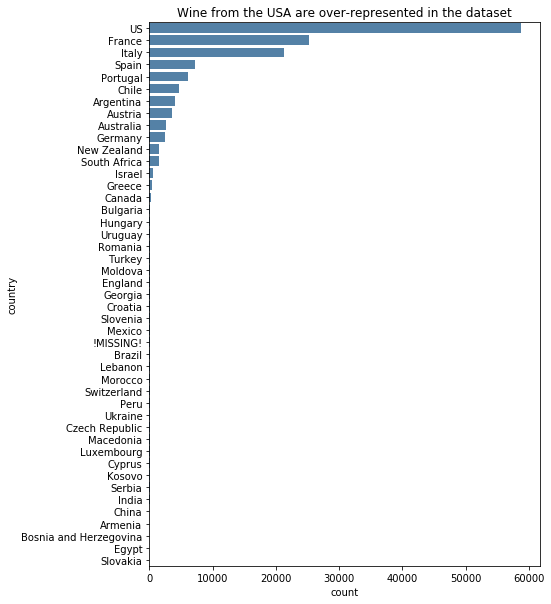

In [12]:
my_barplot(raw_winedata, 'country', title='Wine from the USA are over-represented in the dataset', fig_height=10)

#### Variety

There are 758 different varieties in the dataset
If we keep only the varieties represented by 500 wines or more, 
we still have 122856 wines in the dataset, and 42 unique varieties:


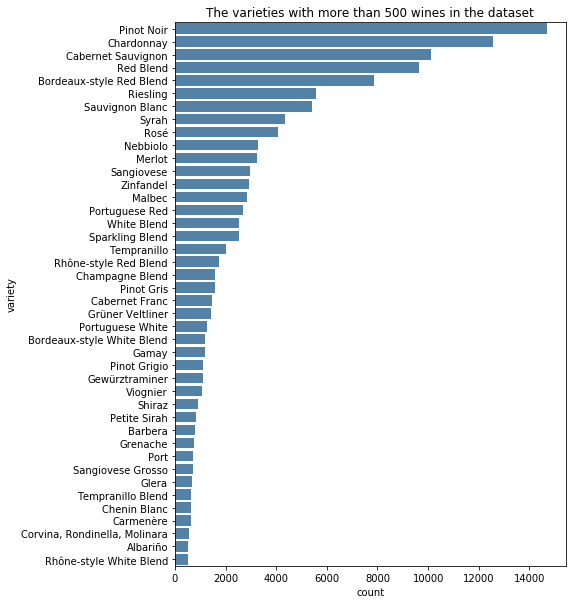

In [13]:
threshold_n_wines = 500
variety_counts = raw_winedata.variety.value_counts()

print('There are', raw_winedata.variety.nunique(), 'different varieties in the dataset')
print('If we keep only the varieties represented by', threshold_n_wines, 'wines or more, ')
print('we still have', 
     raw_winedata[raw_winedata.variety.isin(variety_counts.index[variety_counts > threshold_n_wines])].shape[0],
     'wines in the dataset, and', 
     raw_winedata[raw_winedata.variety.isin(variety_counts.index[variety_counts > threshold_n_wines])].variety.nunique(),
     'unique varieties:')

my_barplot(raw_winedata[raw_winedata.variety.isin(variety_counts.index[variety_counts > threshold_n_wines])], 
           'variety', 
           title='The varieties with more than '+str(threshold_n_wines)+' wines in the dataset', 
           fig_height=10)


#### Province

There are 456 different provinces in the dataset
If we keep only the provinces represented by 500 wines or more, 
we still have 124904 wines in the dataset, and 41 unique provinces:


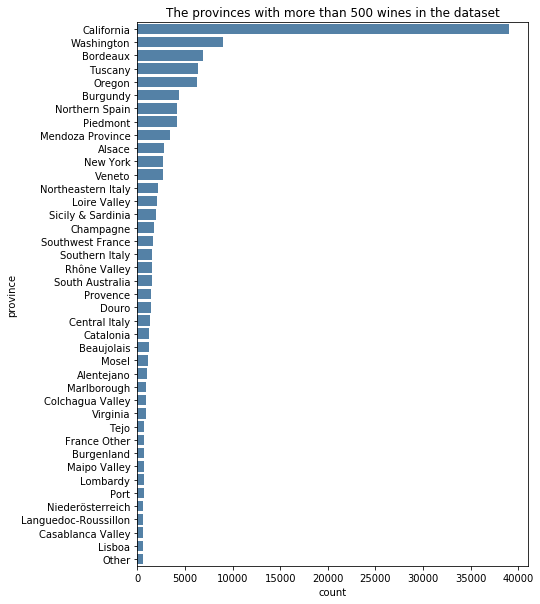

In [14]:
threshold_n_wines = 500
province_counts = raw_winedata.province.value_counts()

print('There are', raw_winedata.province.nunique(), 'different provinces in the dataset')
print('If we keep only the provinces represented by', threshold_n_wines, 'wines or more, ')
print('we still have', 
     raw_winedata[raw_winedata.province.isin(province_counts.index[province_counts > threshold_n_wines])].shape[0],
     'wines in the dataset, and', 
     raw_winedata[raw_winedata.province.isin(province_counts.index[province_counts > threshold_n_wines])].province.nunique(),
     'unique provinces:')

my_barplot(raw_winedata[raw_winedata.province.isin(province_counts.index[province_counts > threshold_n_wines])], 
           'province', 
           title='The provinces with more than '+str(threshold_n_wines)+' wines in the dataset', 
           fig_height=10)


We note that there is a province named "Other". All those wines are coming from Argentina:

In [15]:
raw_winedata[raw_winedata.province == 'Other'].country.value_counts()

Argentina    546
Name: country, dtype: int64

There is one other province in Argentina, Mendoza:

In [16]:
raw_winedata[raw_winedata.country == 'Argentina'].province.value_counts()

Mendoza Province    3451
Other                546
Name: province, dtype: int64

Thus, we will rename the province "Other" to "Argentina Other" during the data processing step below.

#### Taster

Unfortunately a large portion of the data lack a tester name. This has to be kept in mind if we want to check the assumption that their is an "universal" way of describing wine and that vocabulary of the different taster is similar.  

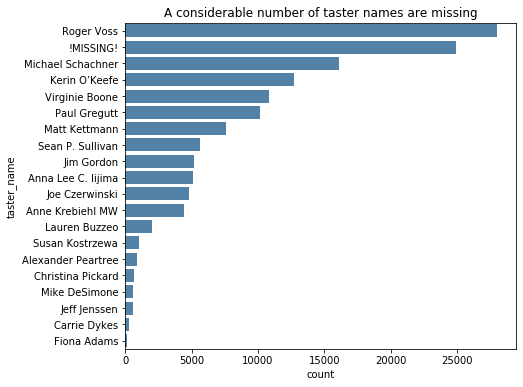

In [17]:
my_barplot(raw_winedata, 'taster_name', title='A considerable number of taster names are missing', fig_height=6)

The variables that we just explored are the most significant for this project. Let's have a quick look at the points attributed to the wine.

#### Points

Note that wines with a review less than 80 points are not reviewed, thus not in the dataset. An alternative project with this dataset could be to try to predict the points based on the text descriptions.  

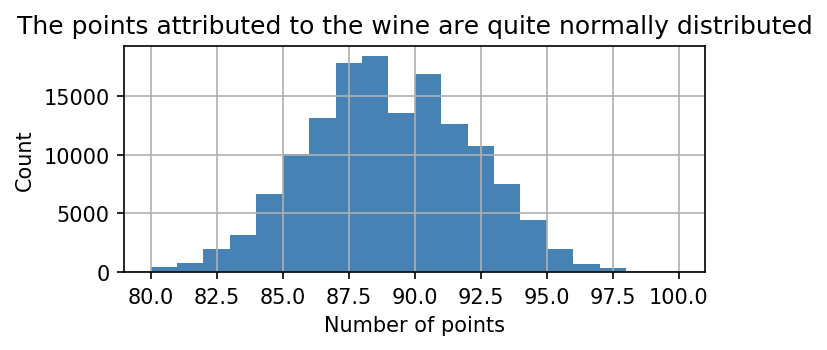

In [18]:
# distribution of points attributed to the wines:
plt.figure(figsize=(5,2), dpi=150)
raw_winedata.points.hist(bins=20, color=mycolor)
plt.xlabel('Number of points')
plt.ylabel('Count')
plt.title('The points attributed to the wine are quite normally distributed')
plt.savefig("../figures/hist_points.png", bbox_inches='tight')
plt.show()

**This dataset is a sample that is not representative of the wine production in the world**. It only represent what was could be scraped on the WineEnthusiast website, which is aimed at the american wine market. There is thus an important sampling bias in this dataset. More will be commented on this in the presentation.


## 2. Data Processing

In this step, we process, filter and clean the data. The data processing decisions are based on the initial data exploration, but also on later steps in the analysis pipeline.  

### 2.A. Data selection, filtering and handling of missing values

In [19]:
# creation of a dataframe that will contain the processed data:
winedata_processing = raw_winedata.copy()
initial_number_of_rows = winedata_processing.shape[0]

# WARNING: the following code chunks need to be run starting from this one !

In [20]:
# Keep only varieties that occur more than 500 times:
old_number_of_rows = winedata_processing.shape[0]

n = 500
variety_counts = winedata_processing.variety.value_counts()
winedata_processing = winedata_processing[winedata_processing.variety.isin(variety_counts.index[variety_counts.gt(n)])] # pandas.DataFrame.gt = get greater

new_number_of_rows = winedata_processing.shape[0]
print('Number of rows removed: ', old_number_of_rows-new_number_of_rows, 
      '. New number of rows:', winedata_processing.shape[0])


Number of rows removed:  18761 . New number of rows: 122856


In [21]:
# Renaming the province "Other" to "Argentina Other":
winedata_processing.loc[:,'province'] = np.where(winedata_processing.province == 'Other', 
                                                'Argentina Other',
                                                winedata_processing.province)

In [22]:
# Keep only provinces that occur more than 500 times:
old_number_of_rows = winedata_processing.shape[0]

n = 500
province_counts = winedata_processing.province.value_counts()
winedata_processing = winedata_processing[winedata_processing.province.isin(province_counts.index[province_counts.gt(n)])]

new_number_of_rows = winedata_processing.shape[0]
print('Number of rows removed: ', old_number_of_rows-new_number_of_rows, 
      '. New number of rows:', winedata_processing.shape[0])

Number of rows removed:  15932 . New number of rows: 106924


In [23]:
# Remove duplicate descriptions:
old_number_of_rows = winedata_processing.shape[0]

# Note: we are conservative, and do not keep any version of the duplicates
winedata_processing = winedata_processing.drop_duplicates(subset='description', keep=False)

new_number_of_rows = winedata_processing.shape[0]
print('Number of rows removed: ', old_number_of_rows-new_number_of_rows, 
      '. New number of rows:', winedata_processing.shape[0])

Number of rows removed:  44 . New number of rows: 106880


In [24]:
# remove descrptions that are shorter than 45 characters long:
old_number_of_rows = winedata_processing.shape[0]

winedata_processing = winedata_processing[winedata_processing.description.apply(len) > 45]
# short_descr = raw_winedata[raw_winedata.description.apply(len) < 45].description
new_number_of_rows = winedata_processing.shape[0]
print('Number of rows removed: ', old_number_of_rows-new_number_of_rows, 
      '. New number of rows:', winedata_processing.shape[0])

Number of rows removed:  7 . New number of rows: 106873


In [25]:
# remove wines coming from the province "other":
old_number_of_rows = winedata_processing.shape[0]

winedata_processing = winedata_processing[winedata_processing.province != 'Other']
# short_descr = raw_winedata[raw_winedata.description.apply(len) < 45].description
new_number_of_rows = winedata_processing.shape[0]
print('Number of rows removed: ', old_number_of_rows-new_number_of_rows, 
      '. New number of rows:', winedata_processing.shape[0],
     '. They were apparently already removed with during the previous cleaning steps.')

Number of rows removed:  0 . New number of rows: 106873 . They were apparently already removed with during the previous cleaning steps.


In [26]:
# We drop the columns "taster_twitter_handle" and "vintage",
# as they are useless for this analysis
winedata_processing.drop(['taster_twitter_handle', 'vintage'], axis=1, inplace=True)

In [27]:
# finally, we save the processed data in a new dataframe, that we will use for the rest of the project:
winedata = winedata_processing.copy()

# and we reset the indexes of the data:
winedata.reset_index(inplace=True, drop=True)

In [28]:
print("We have now a dataset of", winedata.shape[0], 'rows with', 
      winedata.shape[1], 'features.')

We have now a dataset of 106873 rows with 12 features.


### 2.B. Tokenization and cleaning of the text descriptions

We add a new column in the dataframe with the tokenized and clean descriptions, using a custom tokenizer.    

The corpus-specific stopwords (domain_specific_stopwords, variety_stopwords, province_stopwords) listed below have been updated after an initial iteration of building the recommendation system and the observations collected.  Notably, we would prefer to not have wine varieties and province inside the text descriptions, as our goal is to recommand wines based on the taste description.  

In [29]:
domain_specific_stopwords = ['$', ' ', '’s', 'wine', 'winemaker', 'winemaking', 'winery',
                             'château', 'village', 'domaine',
                             'côte', 'saint', 'village', 'parcel', 'parcels',
                             'I', 'flavors', 'vineyard', 'vintage',
                             'now-2015', 'now-2018', 'now-2025', 
                             '2015', '2016', '2017', '2018', '2019', '2020', # not sure why these numbers are not...
                             '2021', '2022', '2023', '2025', '2028', '2030'] # cleand by spacy "is_digit/like_num"
# Other potential words to consider removing:
# douro, nacional, widely, muscat, willamette, bordeaux, pommard, rioja, barbaresco, chianti...

# a list of all wine varieties. this is not perfect as some varieties are compound words. But it's a start.
variety_stopwords = winedata.variety.unique().tolist()
variety_stopwords = [str(variety).lower() for variety in variety_stopwords] # convert to lowercase
# we add some notable varieties to the list:
variety_stopwords = variety_stopwords + ['pinot', 'gris', 'noir', 'grigio', 'cabernet', 
                                         'cabernets', 'sauvignon', 'sirah', 'tempranillo', 
                                         'chenin', 'sangiovese', 'grüner', 'veltliner', 'corvina', 
                                         'rondinella', 'molinara', 'franc', 'blanc', 'blend',
                                         'franc', 'mourvèdre']

# a list of all wine provinces. 
province_stopwords = winedata.province.unique().tolist()
province_stopwords = [str(province).lower() for province in province_stopwords] # convert to lowercase
# we add some notable province-related words to the list:
province_stopwords = province_stopwords + ['france', 'sicily', 'sardinia', 'mendoza', 'spain', 
                                           'australia', 'italy', 'loire', 'beaujolais']


In [30]:
# Standard model used for tokenization.
# When using another model, we will have to load it and redefine "nlp"

# We do not need word vectors here, so we can upload the small English model from spaCy:
# We do not need PoS tags, dependencies or named entities, so we disable them (run faster!):
nlp = spacy.load('en_core_web_sm', disable=['tagger', 'parser', 'ner'])

In [31]:
def tokenize_and_clean(description):
    """
        Our basic tokenizer function. It takes as input:
            - a pd.Series of the descriptions
            - a nlp model
        After tokenizing, it cleans the data too,
        and returns a list of tokens. 
    """
    
#     # eventually clean the description with regular expressions here:
#     pattern = "[\[].*?[\]]" # an example of an regex
#     description = re.sub(pattern, "", description) # remove this pattern from description.

    # Tokenize:
    mytokens = nlp(description)

    # Removing stopwords, punctuation, numbers and convert to lower_case
    mytokens = [token.lower_ for token in mytokens if not token.is_punct and not token.is_stop and not token.like_num and not token.is_digit]
    
    # remove domain-specific stopwords:
    mytokens = [token for token in mytokens if token not in domain_specific_stopwords]
            
    # remove wine variety occurrences in the descriptions:
    mytokens = [token for token in mytokens if token not in variety_stopwords]
    
    # remove wine province occurrences in the descriptions:
    mytokens = [token for token in mytokens if token not in province_stopwords]
                
    # Return preprocessed list of tokens
    return mytokens


In [32]:
# Tokenization:
time0 = time.time()

# we store our tokenized descriptions in a new column of the dataframe, 
# in the form of a list of words,
# which we will be able to use later in the analysis as input for different algorithms.

winedata.loc[:,'tokenized_descriptions'] = winedata.description.apply(tokenize_and_clean)

print('Done! Tokenization took', time.time()-time0, 'seconds.')

Done! Tokenization took 27.07409429550171 seconds.


In [33]:
def concatenate_list_of_words_in_one_string(list_of_words):
    """
        build one string with a list of words, with a space in the middle
    """
    return " ".join(list_of_words)

In [34]:
# we also store our tokenized descriptions as one string, 
# as it will be useful later, e.g. to compute tf-ifd.
winedata.loc[:,'token_descr_as_string'] = winedata.tokenized_descriptions.apply(
    concatenate_list_of_words_in_one_string)


In [35]:
# a csv where we save our processed data:
winedata.to_csv(path_or_buf='../data/winedata_processed_and_tokenized.csv', index=False)

## 3. Deeper Data Understanding (after processing and cleaning)

We do some bivariate plots and apply some supervised learning techniques to better understand the data and test some of our assumptions before building the recommender system.


### Bivariate Relationships

We suppose that wines from different provinces or variety taste differently and suppose that province and variety are two of the main drivers of the difference of taste between wines. If so, this differences should (hopefully) be reflected in the words used for describing the wines by the tasters.  

Tasters can use a different vocabulary when describing the wines because :
1. they tasted wines that are very different (e.g. their variety and origin differs), i.e. sampling bias for tasters 
2. they generally use a completely different vocabulary to describe the wine.  

To test the first hypothesis, we can plot the bivariate distribution between taster names and province/variety. The second hypothesis is not true as such, but it might still be that their vocabular slightly differ. We might see this effect when we build our recommendation system.  

#### Taster and Variety

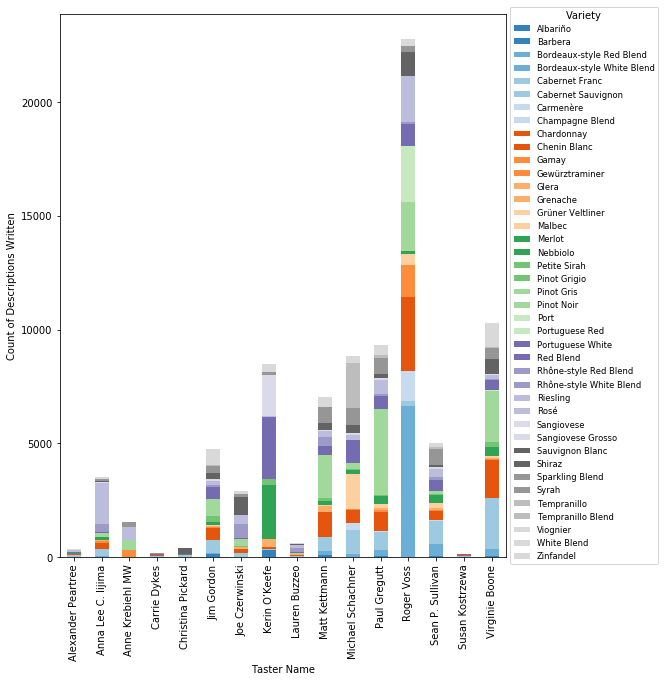

In [36]:
# COULD BE DONE: reverse order of legend.
toplot_stackedbar = winedata.groupby(['taster_name', 'variety'], as_index=False).count()
toplot_stackedbar = toplot_stackedbar[['taster_name', 'variety', 'title']]
toplot_stackedbar = toplot_stackedbar.pivot(index='taster_name', columns='variety', values='title')

toplot_stackedbar.plot(kind='bar', stacked=True, figsize=(8,10), cmap = 'tab20c') # 'hsv'
plt.legend(title='Variety', bbox_to_anchor=(1.35, 0.5), 
           loc='center right', fontsize='small')
plt.xlabel("Taster Name")
plt.ylabel("Count of Descriptions Written")
plt.savefig("../figures/stackedbar_n_descr_by_author_variety.png", bbox_inches='tight', dpi=200)
plt.show()

We note that the tasters did review a very different number of wines, and also that the distribution of wine varieties by taster vary greatly too.

In [37]:
# # TO DO, PLOT THE SAME DATA AS PERCENTAGE, not sure why not working...
# # stacked percentage barplot:
# toplot_percbar = toplot_stackedbar.fillna(0)
# toplot_percbar = (100. * toplot_percbar / toplot_percbar.sum())
# toplot_percbar.plot(kind='bar', stacked=True)
# toplot_percbar

#### Taster and Province

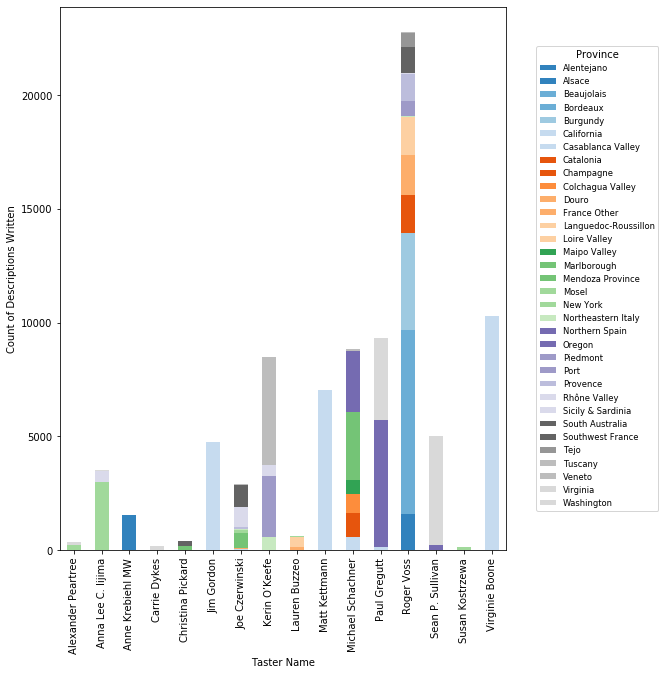

In [38]:
# COULD BE DONE: reverse order of legend.
toplot_stackedbar = winedata.groupby(['taster_name', 'province'], as_index=False).count()
toplot_stackedbar = toplot_stackedbar[['taster_name', 'province', 'title']]
toplot_stackedbar = toplot_stackedbar.pivot(index='taster_name', columns='province', values='title')

toplot_stackedbar.plot(kind='bar', stacked=True, figsize=(8,10), cmap = 'tab20c') # 'hsv'
plt.legend(title='Province', bbox_to_anchor=(1.35, 0.5), 
           loc='center right', fontsize='small')
plt.xlabel("Taster Name")
plt.ylabel("Count of Descriptions Written")
plt.savefig("../figures/stackedbar_n_descr_by_author_province.png", bbox_inches='tight', dpi=200)
plt.show()

The distribution of provinces reviewed vary greatly too. For instance, some tasters did only review wine from California.   

### Vocabulary

Some stats about the corpus.

In [39]:
corpus = list(itertools.chain(*winedata.tokenized_descriptions)) # should be faster than solution below
# corpus = [y for x in descriptions for y in x]

# the corpus is here a list of all the -clean- words found in the descriptions.
# we transform it to a dataframe
corpus = pd.DataFrame(corpus, columns=['word'])
print('Number of words in corpus: ', len(corpus))
print('Number of unique words in corpus: ', corpus.nunique())
print('On average, the tokenized and cleaned descriptions contain', 
     np.mean(winedata.tokenized_descriptions.apply(len)), 'words.')


Number of words in corpus:  2320934
Number of unique words in corpus:  word    28430
dtype: int64
On average, the tokenized and cleaned descriptions contain 21.71674791575047 words.


In [40]:
# a very long string that is our full corpus
# needed for wordclouds
text_corpus = concatenate_list_of_words_in_one_string(list(corpus.word))

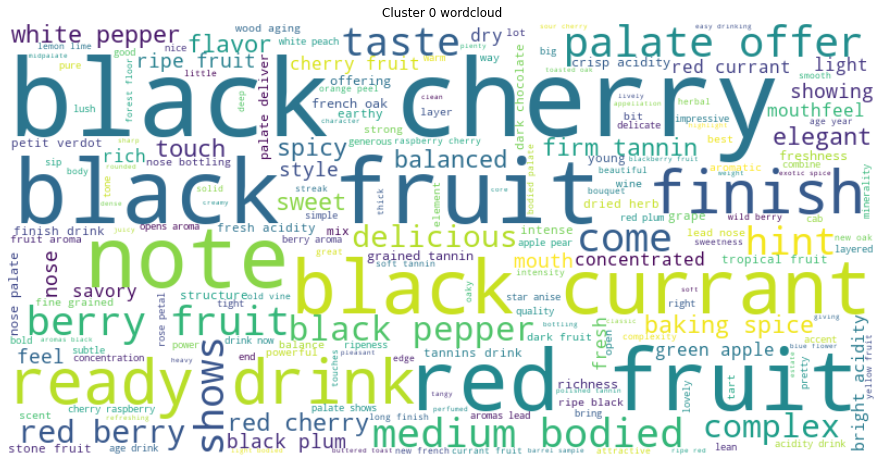

Done in 12.312418699264526 seconds


In [41]:
# could do here: wordclouds 
time0 = time.time()

wordcloud = WordCloud(background_color="white", width=800, height=400).generate(text_corpus)

# Display the generated image:
plt.figure(figsize=(16,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Cluster 0 wordcloud")
plt.axis("off")
wordcloud.to_file("../figures/wordcloud_corpus.png")
plt.show()

print('Done in', time.time() - time0, 'seconds')

## 4. Testing Different Recommendation Systems

We will try different recommendations systems, starting from the "simpler". They always consist of 2 steps: first a vectorization, where all the description are transformed to vectors, then a measure of similarity between those vectors to find the most similar wine to the target wine.  

1. BoW vectors and cosine similarity
2. tf-idf vectors and cosine similarity
3. pre-trained word2vec and cosine similarity
4. word2vec trained on the dataset
5. Topic modelling

For each of these systems, we will compare their top 5 recommendations for the most similar wine to two target wines that we really enjoyed last dinner, a red pinot noir from Oregon and a with a Gewürztraminer from Alsace. 

1. $winedata.iloc[14,:]$ "**Acrobat 2013 Pinot Noir (Oregon)**", described as "A sleek mix of tart berry, stem and herb, along with a hint of oak and chocolate, this is a fair value in a widely available, drink-now Oregon Pinot. The wine oak-aged for six months, whether in neutral or re-staved is not indicated.". We tokenized (unigram) the description as following: 'sleek', 'mix', 'tart', 'berry', 'stem', 'herb', 'hint', 'oak', 'chocolate', 'fair', 'value', 'widely', 'available', 'drink', 'oak', 'aged', 'months', 'neutral', 'staved', 'indicated'.  

2. $winedata.iloc[7,:]$ "**Leon Beyer 2012 Gewurztraminer (Alsace)**", described as "This is a dry wine, very spicy, with a tight, taut texture and strongly mineral character layered with citrus as well as pepper. It's a food wine with its almost crisp aftertaste.". We tokenized (unigram) the description as following: 'dry', 'spicy', 'tight', 'taut', 'texture', 'strongly', 'mineral', 'character', 'layered', 'citrus', 'pepper', 'food', 'crisp', 'aftertaste'.

We vectorize our descriptions and compute the cosine distance with a target wine. This cosine distance will be our measure of similarity.     

As the computation of a full pairwise similarity matrix is too costly (it results in a ~100'000x100'000 matrix, the number of wines in the dataset), we compute the cosine similarity between one target wine vector and the full vectors and obtain a vector of similarities of 1x100'000. Then we sort it and select the top n wines that have the highest similarity to the target. Those will be our best recommendations.   

We define below some functions that will help us.

In [42]:
def print_wines(wine_indexes):
    """
        a generic function to print the most important feature of a or several wine(s).
        from their index(es): ! wine_indexes must be a list !
    """
    # print most important characteristic of wine(s),
    # from their index(es).
    # ! wine_indexes must be a list
    for index_ in wine_indexes:
        current_wine = winedata.loc[index_, :]
        print(current_wine[['title', 'country', 'province', 'region_1', 'variety', 'taster_name']])
        print('Desciption: ', current_wine.description)
        print('Tokens: ', current_wine.tokenized_descriptions)
        print('------------------------------------------------------\n')

In [43]:
print_wines([14, 7]) # our two "target" wines

title          Acrobat 2013 Pinot Noir (Oregon)
country                                      US
province                                 Oregon
region_1                                 Oregon
variety                              Pinot Noir
taster_name                        Paul Gregutt
Name: 14, dtype: object
Desciption:  A sleek mix of tart berry, stem and herb, along with a hint of oak and chocolate, this is a fair value in a widely available, drink-now Oregon Pinot. The wine oak-aged for six months, whether in neutral or re-staved is not indicated.
Tokens:  ['sleek', 'mix', 'tart', 'berry', 'stem', 'herb', 'hint', 'oak', 'chocolate', 'fair', 'value', 'widely', 'available', 'drink', 'oak', 'aged', 'months', 'neutral', 'staved', 'indicated']
------------------------------------------------------

title          Leon Beyer 2012 Gewurztraminer (Alsace)
country                                         France
province                                        Alsace
region_1                 

In [44]:
def return_target_vector(data_features, target_index):
    """
        given the index of a target wine,
        return the vectors of features 
        associated to this wine/index
        in the form of an "horizontal array",
        so it can be taken as input in the 
        sklearn.metrics.pairwise.cosine_similarity() fct.
    """
    target = data_features.iloc[target_index,:]
    return target.values.reshape(-1, 1).T

def compute_cosine_similarity_btw_target_and_features(data_features, target_vector):
    """
        takes a few seconds
    """
    return cosine_similarity(target_vector, data_features)

In [45]:
def recommend_top_n_wines(data_features, target_index, top_n ):
    """
        given a wine index (target_index), return the top_n
        most similar wine according to cosine distance with 
        other wines (data_features)
    """
    # get vector of target:
    target_vector = return_target_vector(data_features, target_index)
    
    # compute cosine distance: (takes a few seconds)
    cos_sim = compute_cosine_similarity_btw_target_and_features(data_features, target_vector)
    
    # build dataframe and add indexes based on input data:
    similarities = pd.DataFrame(cos_sim.T, columns=['cosine_sim'], index=bow_features.index)
    
    # sort and select top_n indexes (start at 1 to remove similarity with itself)
    moost_similar = similarities.sort_values('cosine_sim', ascending=False)[1:top_n+1]
    
    # return the indexes of those most similar wines:
    return list(moost_similar.cosine_sim.index)
    
    

### 4.A BoW + Cosine Similarity

The simplest model is building vectors with the count of words by desccription: the so-called Bag of Words (BoW).

In [46]:
# vectorization using BoW :
time0 = time.time()

# note: we only keep 2000 features:
bow_vectorizer = CountVectorizer(ngram_range=(1,1), # 1-gram
                               max_df=0.95, # ignore t that have a df higher than max_df (corpus-specific stopwords)
                               min_df=10, # ignore terms that have a doc freq lower than threshold.
                               max_features=2000, # max number of features
                              )
# Applying the vectorizer on the "clean" descriptions:
wine_bow = bow_vectorizer.fit_transform(winedata.token_descr_as_string)

# list of features
terms_bow = bow_vectorizer.get_feature_names()

# store the features in a dataframe:
bow_features = pd.DataFrame(wine_bow.toarray(), columns=terms_bow)

print('Done! Vectorization took', time.time()-time0, 'seconds.')

Done! Vectorization took 2.7428879737854004 seconds.


Below is an example of recommendations for this simple recommender system. We find the 5 wines that are the most similar to our target wine [index 14] in the vector space defined by our BoW model:

In [121]:
print('#winerec: "Here are my top 5 recommendations for you, enjoy!"')

#winerec: "Here are my top 5 recommendations for you, enjoy!"


In [47]:
# search for the most similar wines:
recommended_wines_bow = recommend_top_n_wines(bow_features, target_index=14, top_n=5)

# print results:
print('Hey #winerec, which wine should I drink if I enjoyed this one a lot?\n')
print_wines([14])
print('\n')
print('#winerec talking: Here are my top 5 recommendations, enjoy!\n')
print_wines(recommended_wines_bow)

Hey #winerec, which wine should I drink if I enjoyed this one a lot?

title          Acrobat 2013 Pinot Noir (Oregon)
country                                      US
province                                 Oregon
region_1                                 Oregon
variety                              Pinot Noir
taster_name                        Paul Gregutt
Name: 14, dtype: object
Desciption:  A sleek mix of tart berry, stem and herb, along with a hint of oak and chocolate, this is a fair value in a widely available, drink-now Oregon Pinot. The wine oak-aged for six months, whether in neutral or re-staved is not indicated.
Tokens:  ['sleek', 'mix', 'tart', 'berry', 'stem', 'herb', 'hint', 'oak', 'chocolate', 'fair', 'value', 'widely', 'available', 'drink', 'oak', 'aged', 'months', 'neutral', 'staved', 'indicated']
------------------------------------------------------



#winerec talking: Here are my top 5 recommendations, enjoy!

title          Evening Land 2014 Seven Springs Estate Vie

All are from Oregon and were tasted by the same person. Is it a coincidence? Before discussind and trying to evaluate these results in more details, we will try other models and compare their output.  

### 4.B tf-idf + Cosine Similarity

This is a similar model, but we compute the similarity between wines in a tf-idf vector space. 

In [48]:
# vectorization using tf-idf :
time0 = time.time()

# note: we only keep 2000 features:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1), # 1-gram
                               max_df=0.95, # ignore t that have a df higher than max_df (corpus-specific stopwords)
                               min_df=10, # ignore terms that have a doc freq lower than threshold.
                               max_features=2000, # max number of features
                              )
# Applying the vectorizer on the "clean" descriptions:
wine_tfidf = tfidf_vectorizer.fit_transform(winedata.token_descr_as_string)

# list of features
terms_tfidf = tfidf_vectorizer.get_feature_names()

# store the features in a dataframe:
tfidf_features = pd.DataFrame(wine_tfidf.toarray(), columns=terms_tfidf)

print('Done! Vectorization took', time.time()-time0, 'seconds.')

Done! Vectorization took 3.5894830226898193 seconds.


In [49]:
# search for the most similar wines:
recommended_wines_tfidf = recommend_top_n_wines(tfidf_features, target_index=14, top_n=5)


In [50]:
# # uncomment to print the results
# # print results:
# print('Hey #winerec, which wine should I drink if I enjoyed this one a lot?\n')
# print_wines([14])
# print('\n')
# print('#winerec talking: Here are my top 5 recommendations, enjoy!\n')
# print_wines(recommended_wines_tfidf)

### 4.C tf-idf bigrams + Cosine Similarity

We noticed when reading a few descriptions and during the data exploration step that it might be worth looking at bigrams. Indeed, some taste qualifiers tipically consist of 2 words, like for instance: _tropical fruit_, _dried herb_, _dried sage_, _sour plums_, _dusty tannins_.  

We will keep as features the _unigrams_ AND _bigrams_ that have the highest tf-idf. I.e. our 2000 features are a mix of unigrams and bigrams. After inspection, it is not worth going for n-grams with n>2 (change *ngram_range* in *TfidfVectorizer*. This not so surprizing as we cleaned our text "quite intensively", removing diverse types of stopwords.  

In [51]:
# vectorization on BIGRAMS using tf-idf :
time0 = time.time()

# note: we only keep 2000 features:
tfidf_bigram_vectorizer = TfidfVectorizer(ngram_range=(1,2), # unigram and bigram (min, max)
                               max_df=0.95, # ignore t that have a df higher than max_df (corpus-specific stopwords)
                               min_df=10, # ignore terms that have a doc freq lower than threshold.
                               max_features=2000, # max number of features
                              )
# Applying the vectorizer on the "clean" descriptions:
wine_tfidf_bigram = tfidf_bigram_vectorizer.fit_transform(winedata.token_descr_as_string)

# list of features
terms_tfidf_bigram = tfidf_bigram_vectorizer.get_feature_names()

# store the features in a dataframe:
tfidf_bigram_features = pd.DataFrame(wine_tfidf_bigram.toarray(), columns=terms_tfidf_bigram)

print('Done! Vectorization took', time.time()-time0, 'seconds.')

Done! Vectorization took 9.31734299659729 seconds.


In [52]:
# # uncomment to inspect the unigrams and bigrams chosen as features:
# print(terms_tfidf_bigram)

In [53]:
# search for the most similar wines:
recommended_wines_tfidf_bigram = recommend_top_n_wines(tfidf_bigram_features, target_index=14, top_n=5)


In [54]:
# # uncomment to print the results
# # print results:
# print('Hey #winerec, which wine should I drink if I enjoyed this one a lot?\n')
# print_wines([14])
# print('\n')
# print('#winerec talking: Here are my top 5 recommendations, enjoy!\n')
# print_wines(recommended_wines_tfidf_bigram)

### 4.D pre-trained word2vec + cosine similarity

The word2vec model proposed by spaCy is trained on the [Common Crawl dataset](http://commoncrawl.org/). The disadvantage of this pre-trained model is that the data it used to train it might not reflect the peculiarities of the dataset of wine description. On the other end, we would need billion of data to train a good new word2vec model on our data; we only have ~100'000 wine reviews for now.  



In [55]:
# load larger spacy nlp model, that have pre-trained word vectors, unlike the small model:

# We still do not need PoS tags, dependencies or named entities, so we disable them (run faster!):
nlp_md = spacy.load('en_core_web_md', disable=['tagger', 'parser', 'ner'])
# takes a few seconds

In [56]:
# vectorize the clean and processed descriptions
# apply spaCy model on clean data to get word2vec vector
descriptions_word2vec = winedata.token_descr_as_string.apply(nlp_md) 

In [57]:
# we extract the vector attributes of the spacy object
descriptions_word2vec_vectors = [descr.vector for descr in descriptions_word2vec]

n_dim_vectors = len(descriptions_word2vec_vectors[0])
print('features are', n_dim_vectors, 'dimensions vectors') # features are 300 dimensions vectors

# create features names
features_names = list(range(0, n_dim_vectors))
features_names = ['f'+str(i) for i in features_names]

# create a dataframe with features (word2vec vectors) as columns and wine indexes as index
pretrained_word2vec_features = pd.DataFrame(descriptions_word2vec_vectors, 
                                            columns=features_names, 
                                            index=winedata.index)
print('Shape of the features:', pretrained_word2vec_features.shape)
pretrained_word2vec_features.head()

features are 300 dimensions vectors
Shape of the features: (106873, 300)


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f290,f291,f292,f293,f294,f295,f296,f297,f298,f299
0,-0.159084,0.151556,-0.091375,-0.216663,0.060374,0.267113,-0.193304,0.200002,-0.077967,1.153212,...,-0.134386,0.068571,-0.222629,-0.086404,-0.412148,0.077141,0.076644,-0.486005,0.104647,0.011726
1,-0.266234,0.107008,-0.047260,-0.142627,0.048183,0.202625,-0.023727,0.147983,0.037657,1.282734,...,-0.085349,0.062646,-0.182010,-0.115452,-0.139977,-0.051843,0.097522,-0.400682,0.052112,0.003740
2,-0.126693,0.252434,0.006041,-0.145907,-0.020090,0.043690,-0.208207,0.255941,0.001707,0.637117,...,0.009742,0.038179,-0.205767,-0.201660,-0.266077,0.203259,0.072692,-0.410848,-0.092037,0.217177
3,-0.076028,0.151551,-0.082833,-0.064775,-0.035083,0.227857,0.048144,-0.049972,-0.087948,1.638700,...,-0.091685,0.060838,-0.207449,0.029507,0.038968,0.081510,0.066009,-0.126978,0.028869,-0.119433
4,-0.143007,0.277624,0.038183,-0.182341,-0.022961,0.317639,-0.057301,0.111317,-0.099029,1.366156,...,-0.086510,0.076488,-0.348332,-0.142161,-0.218571,0.040205,0.251255,-0.294934,0.123314,0.098643


We have now 300 features that represent each description. We can search for the most similar wine to our target again:

In [58]:
recommended_wines_pretrained_word2vec = recommend_top_n_wines(pretrained_word2vec_features, 
                                                              target_index=14, top_n=5)


In [59]:
# # uncomment to print the results
# # print results:
# print('Hey #winerec, which wine should I drink if I enjoyed this one a lot?\n')
# print_wines([14])
# print('\n')
# print('#winerec talking: Here are my top 5 recommendations, enjoy!\n')
# print_wines(recommended_wines_pretrained_word2vec)

### 4.E custom word2vec + cosine similarity

We can still try to train a word2vec model on our dataset, even if we know that we do not have sufficient data. The advantage of this custom word2vec is that it might differentiate better bewteen _taste qualifiers_ that are "in the grand scheme of words" (i.e. in the Common Crawl dataset) all in all quite similar. That is, the vectors describing different tastes like "cherry" or "apple" are probably quite parallel in 300 dimensions; their cosine distance and thus similarity is already high.  

In [60]:
# train the word2vec model on the wine descriptions corpus:
# using gensim
time0 = time.time()

custom_wine_word2vec_model = word2vec.Word2Vec(
    winedata.tokenized_descriptions, # use our clean and processed descriptions, as tokens (and not token_descr_as_string)
    workers=8,     # Number of threads to run in parallel (if your computer does parallel processing).
    min_count=2,   # Minimum word count threshold. ! need to be the same as for tokenize_and_clean
    window=6,      # Number of words around target word to consider.
    sg=0,          # Use CBOW because our corpus is small.
    sample=1e-3 ,  # Penalize frequent words.
    size=300,      # Word vector length.
    hs=1           # Use hierarchical softmax.
)

print('Done! It took ', time.time()-time0, 'sec.')

Done! It took  16.521635055541992 sec.


In [61]:
# List of words in model.
vocab = custom_wine_word2vec_model.wv.vocab.keys()
print('The vector model has', len(vocab), 'words in vocabulary')

The vector model has 17986 words in vocabulary


Does this word2vec model trained on the wine descriptions make any sense? Let's have a look at some terms. Gensim provides a useful fonction to compute similarity between words in the model:

In [62]:
custom_wine_word2vec_model.wv.most_similar('fruit')[:10]

[('fruits', 0.6907259821891785),
 ('fruited', 0.41627204418182373),
 ('fruitiness', 0.4035857915878296),
 ('plum', 0.399223268032074),
 ('cherry', 0.36293941736221313),
 ('fruity', 0.34340137243270874),
 ('abundant', 0.3308483958244324),
 ('piles', 0.32240307331085205),
 ('comingle', 0.3077358603477478),
 ('berries', 0.3021498918533325)]

In [63]:
custom_wine_word2vec_model.wv.most_similar('coffee')[:10]

[('espresso', 0.7174880504608154),
 ('nib', 0.4161592125892639),
 ('cassis', 0.40833544731140137),
 ('coconut', 0.40818876028060913),
 ('mocha', 0.389610230922699),
 ('chicory', 0.3837515115737915),
 ('coffeebean', 0.3799998164176941),
 ('fudge', 0.37776151299476624),
 ('char', 0.3771364390850067),
 ('bittersweet', 0.3741018772125244)]

In [64]:
custom_wine_word2vec_model.wv.most_similar('fermented')[:10]

[('fermentation', 0.7023762464523315),
 ('ferment', 0.5926735997200012),
 ('vinified', 0.5584371089935303),
 ('fermenting', 0.5583747625350952),
 ('ferments', 0.5539116859436035),
 ('regimen', 0.5299530029296875),
 ('bourbon', 0.5166949033737183),
 ('whiskey', 0.5132962465286255),
 ('select', 0.5021891593933105),
 ('telegraphs', 0.49131807684898376)]

In [65]:
custom_wine_word2vec_model.wv.most_similar('french')[:10]

[('hungarian', 0.5570589900016785),
 ('saw', 0.5556470155715942),
 ('quarter', 0.5123331546783447),
 ('barrels', 0.5097487568855286),
 ('bésoleil', 0.5041497945785522),
 ('american', 0.5018423199653625),
 ('barrique', 0.4684011936187744),
 ('york', 0.446445107460022),
 ('sees', 0.42792651057243347),
 ('puncheons', 0.4244738817214966)]

In [66]:
custom_wine_word2vec_model.wv.most_similar('mastered')[:10]

[('alsatian', 0.7216329574584961),
 ('gosset', 0.6922674775123596),
 ('eponymous', 0.6878754496574402),
 ('peju', 0.687774658203125),
 ('taittinger', 0.6833012104034424),
 ('penfolds', 0.6810909509658813),
 ('variable', 0.6781511306762695),
 ('varies', 0.6614772081375122),
 ('prüm', 0.6604723930358887),
 ('brothers', 0.6562985181808472)]

This does not look quite bad and it is fun! The result for the last word tested "mastered" is a bit strange however, it has a quite high similarity to apparently not so similar words.     

We can **visualize our vector model in 2D with PCA**. As this is quite time consuming, it is done in [another notebook](https://github.com/de-la-viz/winerec/blob/master/code/Plot_word2vec_vector_space.ipynb). It turns out that **the variance explained by the 2 PCA components is extremly low and that the 300 dimensions of the word2vec model are not easily reductible**. Nevertheless, we the resulting plot is loaded below. Indeed, we do not identify any pattern in it.  

In [67]:
# # save model in order to load it from the PCA plotting notebook:
# pkl_filename = '../data/custom_wine_word2vec_model.pkl'
# with open(pkl_filename, 'wb') as file:
#     pickle.dump(custom_wine_word2vec_model, file)

Each dot in the plot below is on word2vec feature plotted in 2D after a PCA. Some features, chosen randomly are annotated. The text annotations are adjusted so they do not overlap, and thus not exactly on the dot they refer to.

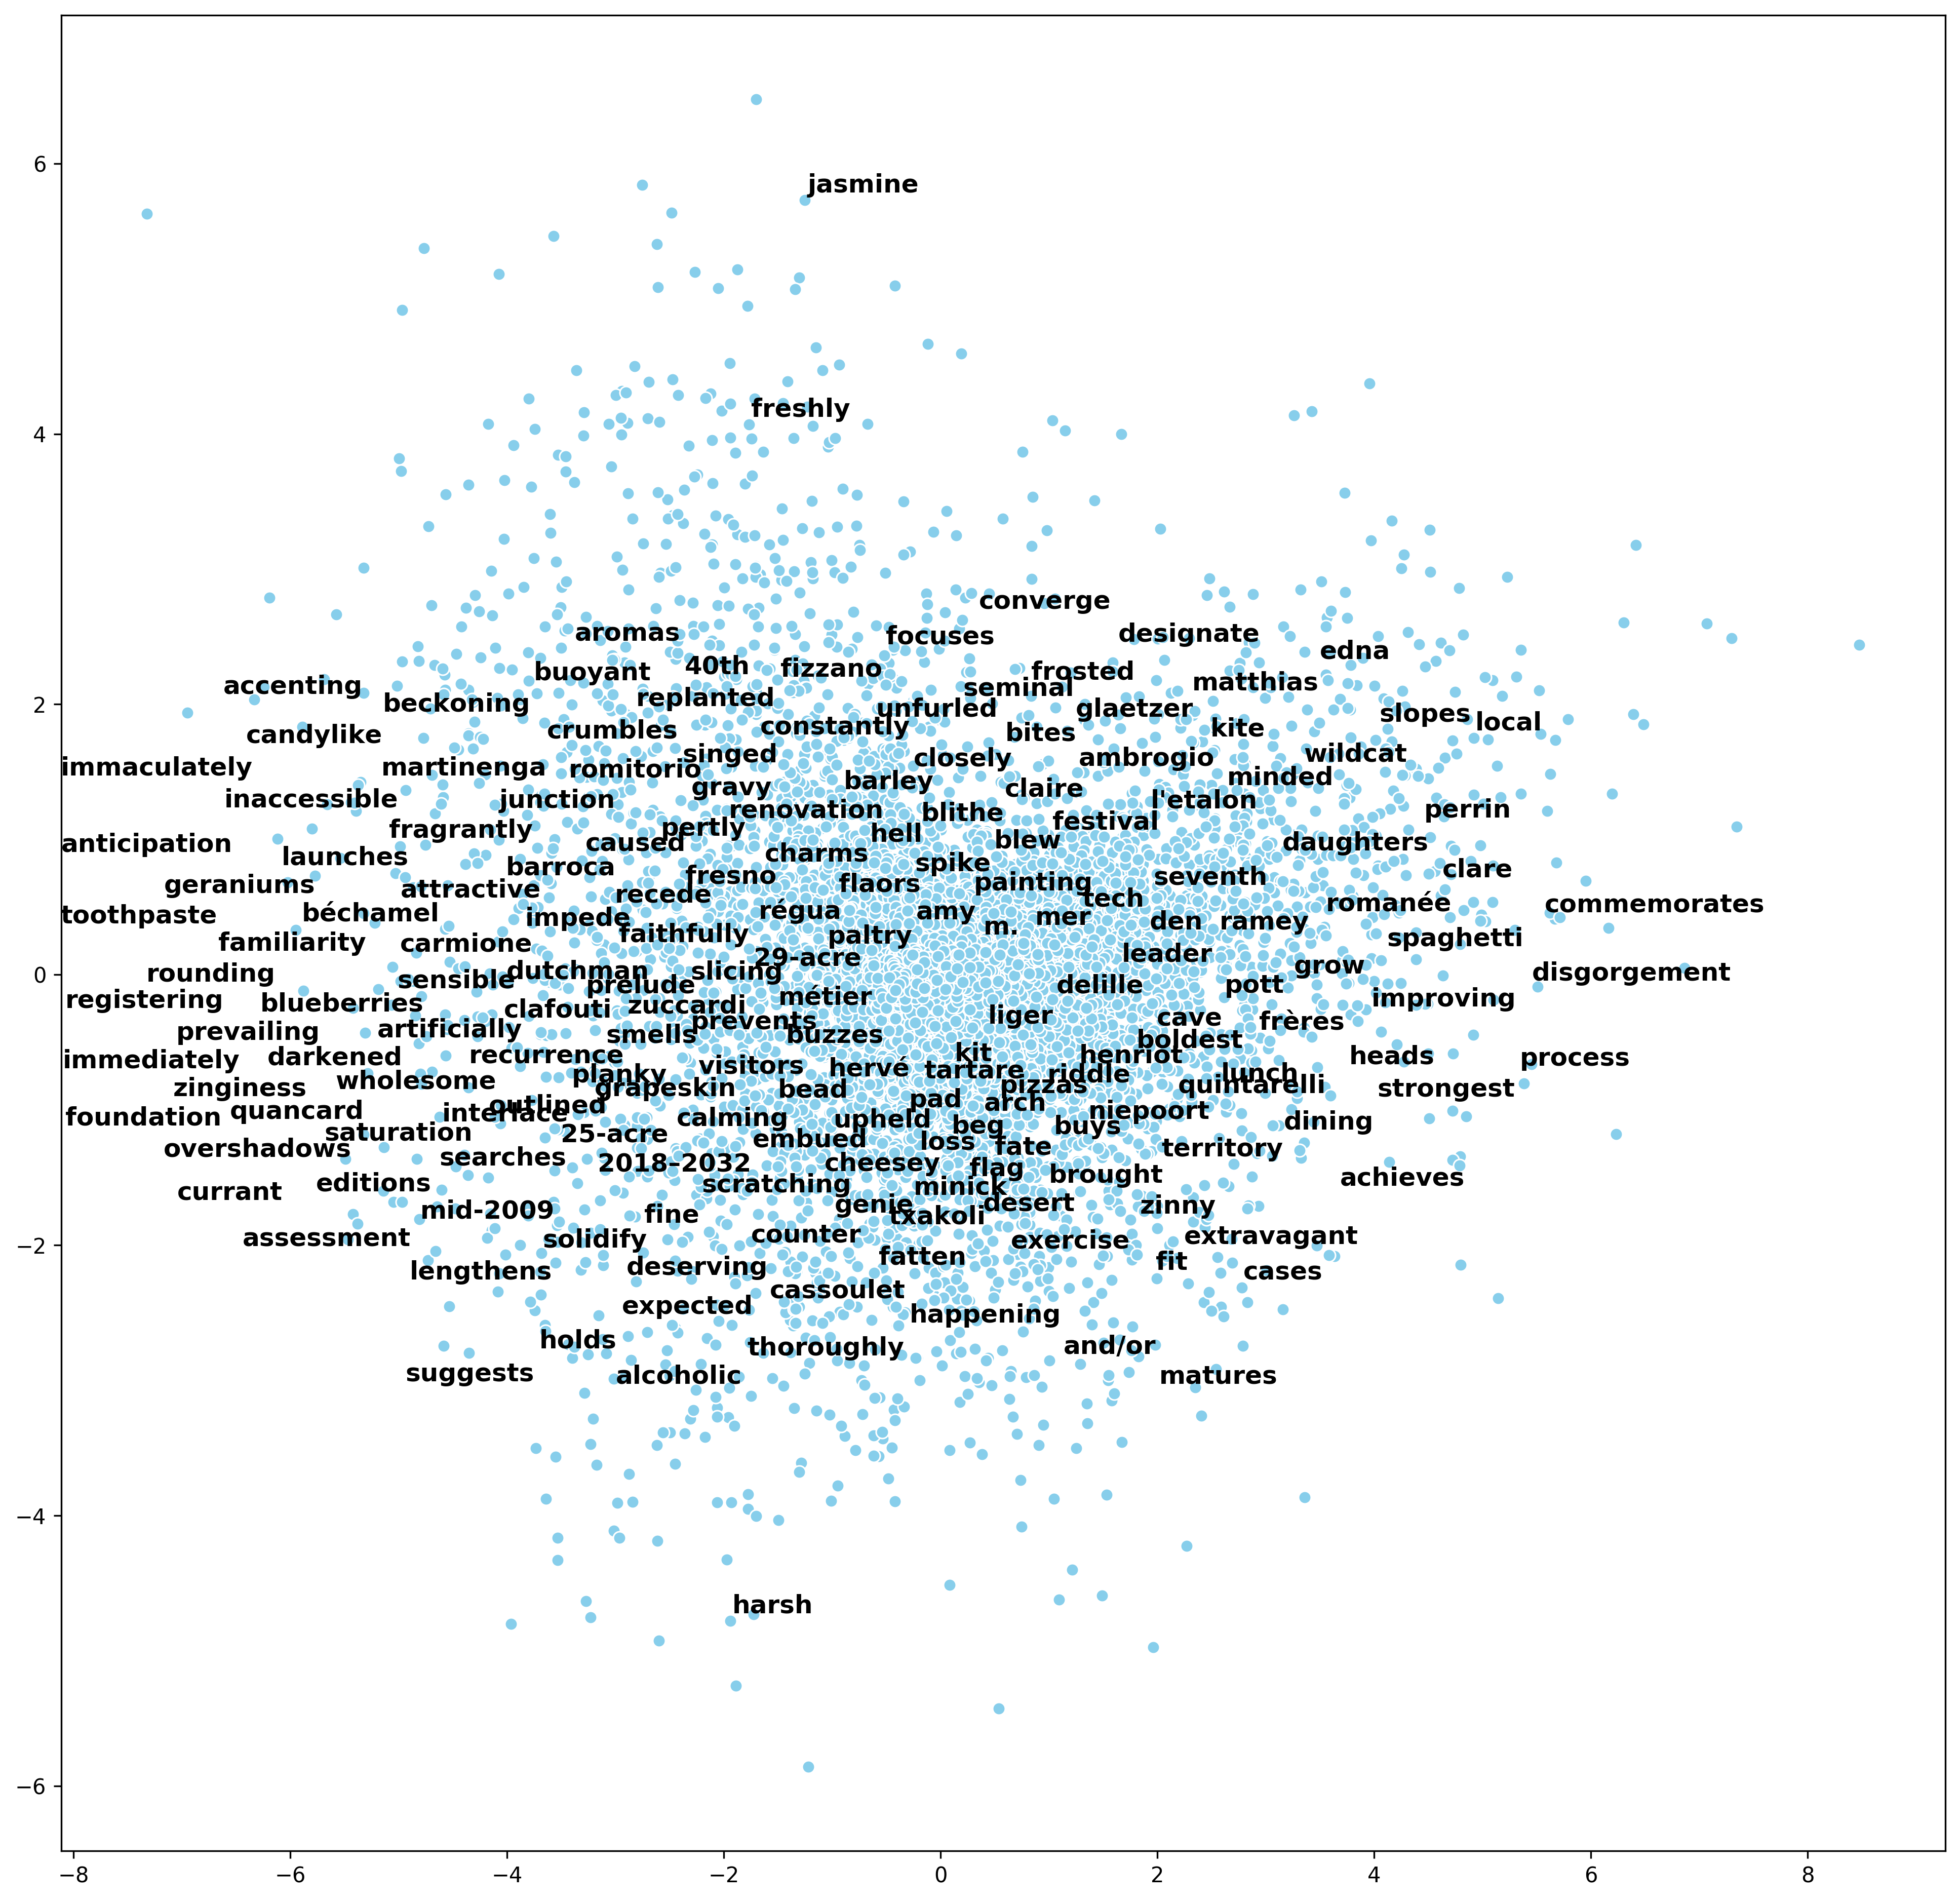

In [68]:
Image(filename='../figures/custom_word2vec_vec_spave_pca.png')

We can still use this custom word2vec model to recommend wines:

In [69]:
winedata.tokenized_descriptions
custom_wine_word2vec_model

In [70]:
time0 = time.time()
descr_vectors = [None] * winedata.tokenized_descriptions.shape[0]
for i, desc in enumerate(winedata.tokenized_descriptions):
    # average vector for each word to get 1 vector per description:
    descr_vectors[i] = np.mean([custom_wine_word2vec_model.wv[word] for word in winedata.tokenized_descriptions[0]], 
                               axis=0) # axis needed to keep 300 dim.
print('done in sec: ', time.time()-time0)

done in sec:  8.415890216827393


In [71]:
# create features names
features_names = list(range(0, len(descr_vectors[0])))
features_names = ['f'+str(i) for i in features_names]

time0 = time.time()

# create a dataframe with features (word2vec vectors) as columns and wine indexes as index
custom_word2vec_features = pd.DataFrame(descr_vectors, columns=features_names, 
                                        index=winedata.index)

print('done in sec: ', time.time()-time0)

done in sec:  13.587986946105957


In [72]:
recommended_wines_custom_word2vec = recommend_top_n_wines(custom_word2vec_features, 
                                                              target_index=14, top_n=5)


In [73]:
# # uncomment to print the results
# # print results:
# print('Hey #winerec, which wine should I drink if I enjoyed this one a lot?\n')
# print_wines([14])
# print('\n')
# print('#winerec talking: Here are my top 5 recommendations, enjoy!\n')
# print_wines(recommended_wines_pretrained_word2vec)

### 4.F LDA topic model + cosine similarity

#### Topic Models

We will try LSA, NMF and LDA. We start with an "educated guest" for the number of topics: 6. Then we will verify if the 3 methods produce similar results. If yes, we will use LDA, because we can make use of the package _pyLDAvis_ to visualize the topics.  

In [74]:
# Definition of some key variables:

# Number of topics:
ntopics = 6

# Number of words to look at for each topic.
n_top_words = 10

# to print the top n words:
topwords = pd.DataFrame(index=range(0,ntopics))

In [75]:
# Some functions needed:

# Linking words to topics
def word_topic(vector_space, solution, wordlist):
    
    # Loading scores for each word on each topic/component.
    words_by_topic = vector_space.T * solution

    # Linking the loadings to the words in an easy-to-read way.
    components = pd.DataFrame(words_by_topic, index=wordlist)
    
    return components

# Extracts the top N words and their loadings for each topic.
def top_words(components, n_top_words):
    n_topics = range(components.shape[1])
    
    index = np.repeat(n_topics, n_top_words, axis=0)
    topwords = pd.Series(index=index) # initiate a Series where to store the topwords of each topic
    fullist=[] # usual code doesn't work
    
    for column in n_topics:
        # Sort the column so that highest loadings are at the top.
        sortedwords = components.iloc[:,column].sort_values(ascending=False)
        # Choose the N highest loadings.
        chosen = sortedwords[:n_top_words]
        # Combine loading and index into a string.
        chosenlist = chosen.index + "  "+ round(chosen,2).map(str)
        
        fullist.append(chosenlist)
    
#     topwords = pd.Series(fullist, index=index)
        
#         topwords.loc[column] = chosenlist
    return(fullist) # (topwords)

#### LSA and NMF

In [76]:
# LSA

time0 = time.time()

svd = TruncatedSVD(ntopics) # prefered to PCA in order to avoid negative loading 
lsa = make_pipeline(svd, Normalizer(copy=False))
wine_lsa = lsa.fit_transform(wine_tfidf_bigram) # using our tf-idf bigram vector space

components_lsa = word_topic(wine_tfidf_bigram, wine_lsa, terms_tfidf_bigram)

topwords['LSA'] = top_words(components_lsa, n_top_words) 

print('Done! It took', time.time()-time0, 'seconds.')


Done! It took 0.5180370807647705 seconds.


In [77]:
# NNMF
time0 = time.time()

nmf = NMF(alpha=0.0, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=ntopics, 
          random_state=0, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )
wine_nmf = nmf.fit_transform(wine_tfidf_bigram) 

components_nmf = word_topic(wine_tfidf_bigram, wine_nmf, terms_tfidf_bigram)

topwords['NMF'] = top_words(components_nmf, n_top_words) 
    
print('Done! It took', time.time()-time0, 'seconds.')

Done! It took 3.711883068084717 seconds.


We can inspect the top 10 words in each topic, and compare the output of LSA to NMF:

In [78]:
# the number is the loading
for i in range(0,ntopics):
    print('topic', i, ':\nLSA:\n', topwords.LSA[i], '\nNMF:\n', topwords.NMF[i],'\n')
    

topic 0 :
LSA:
 fruit         fruit  2830.3
acidity    acidity  2159.45
tannins    tannins  2085.46
aromas      aromas  2081.51
drink        drink  2010.83
black         black  1997.0
palate      palate  1991.45
cherry      cherry  1979.26
ripe          ripe  1963.53
finish       finish  1961.9
dtype: object 
NMF:
 tannins    tannins  45.38
ripe          ripe  42.23
drink        drink  41.54
fruits      fruits  40.76
fruit        fruit  40.54
rich          rich  39.93
black        black  38.47
wood           wood  31.5
acidity    acidity  31.48
aging        aging  27.65
dtype: object 

topic 1 :
LSA:
 acidity            acidity  816.37
drink                drink  680.74
fruits              fruits  670.88
crisp                crisp  630.41
ripe                  ripe  518.92
fruity              fruity  512.79
ready                ready  488.82
ready drink    ready drink  472.81
character        character  465.68
rich                  rich  440.03
dtype: object 
NMF:
 drink               

The topics are quite similar between LSA and NMF. However, some words are repeated in several topics, like "fruit", "tannins" or "acidity". We do not see flagrant pattern emerging from those topics...   

Let's try LDA:

#### LDA

It seems that LDA generally prefer to have term frequencies as input, and not tf-idf (c.f. [this discussion](https://stackoverflow.com/questions/44781047/necessary-to-apply-tf-idf-to-new-documents-in-gensim-lda-model/44789327#44789327). Thus, we will use a tf vectorizer (BoW); and we will allow bigrams.

After a really quick inspection, there are no apparent major differences between the topics proposed by LDA, LSA and NMF. Thus, we will continue with LDA.   

We try to optimize the number of topics when training LDA. This is done in a separate [notebook](), because it is time consuming. We just try several number of topics and inspect the results. We evaluate the results, i.e. the topics, using two techniques: visual inspection (using [pyLDAvis](https://github.com/bmabey/pyLDAvis)) and _log-likelihood_ and _perplexity_ , as seen [here](https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/). The two methods do not necessary converge to the same result, and we will use our human judgment to assess what is a good number of topics.  

We found that we liked the result with **25 topics**:

In [79]:
# train the LDA: ! takes 2-3 min.

ntopics = 25

# 1. vectorization on BIGRAMS using TF (instead of tf-idf) :
time0 = time.time()

# note: we only keep 2000 features:
tf_bigram_vectorizer = CountVectorizer(ngram_range=(1,2), # unigram and bigram (min, max)
                               max_df=0.95, # ignore t that have a df higher than max_df (corpus-specific stopwords)
                               min_df=10, # ignore terms that have a doc freq lower than threshold.
                               max_features=2000, # max number of features
                              )
# Applying the vectorizer on the "clean" descriptions:
wine_tf_bigram = tf_bigram_vectorizer.fit_transform(winedata.token_descr_as_string)

# list of features
terms_tf_bigram = tf_bigram_vectorizer.get_feature_names()

# store the features in a dataframe:
tf_bigram_features = pd.DataFrame(wine_tf_bigram.toarray(), columns=terms_tf_bigram)


# 2. LDA:
lda = LatentDirichletAllocation(n_components=ntopics, 
          doc_topic_prior=None, # Prior = 1/n_documents
          topic_word_prior=1/ntopics,
          learning_decay=0.7, # Convergence rate.
          learning_offset=10.0, # Causes earlier iterations to have less influence on the learning
          max_iter=10, # when to stop even if the model is not converging (to prevent running forever)
          evaluate_every=-1, # Do not evaluate perplexity, as it slows training time.
          mean_change_tol=0.001, # Stop updating the document topic distribution in the E-step when mean change is < tol
          max_doc_update_iter=100, # When to stop updating the document topic distribution in the E-step even if tol is not reached
          n_jobs=-1, # Use all available CPUs to speed up processing time.
          verbose=0, # amount of output to give while iterating
          random_state=0
         )
# the results are stored in a dataframe, with the number of topics as index:
results_lda_TF = lda.fit(wine_tf_bigram)


print('Done! LDA triaining took', time.time()-time0, 'seconds.')


Done! LDA triaining took 153.68781805038452 seconds.


**Visual inspection:**  
The area of the topic circles is _topic prevalence_, i.e. measures the importance of the topics, relative to the data. The number are displayed in order, 1 being the most popular topic. The distance between two topics represents their similarity (in 2D instead of 300D).   

By hovering above a words, we can see its relative prevalence in the different topics (i.e. conditional topic distribution).   

Adjusting lambda (relevance metrics) helps interpreting the topic. Lambda=0 shows "jargon" specific to the topic, words that are exclusively popular (high tf) for this topic. If you increase lambda, you see more blue bars, more words that are also included in other topics appear in the top 30. Playing with the balance helps interpreting the topic.  

_Saliency_: a measure of how much the term tells you about the topic.  

_Relevance_: a weighted average of the probability of the word given the topic and the word given the topic normalized by the probability of the topic.  

In [80]:
# visual inspection of the topics:
pyLDAvis.sklearn.prepare(results_lda_TF, wine_tf_bigram, tf_bigram_vectorizer, mds='mmds') # or mds='PCoA'

/usr/local/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
17    -0.225028 -0.237341       1        1  6.388698
13    -0.041007  0.189496       2        1  6.294701
12    -0.231072  0.308263       3        1  6.143489
22     0.351536 -0.002877       4        1  5.834475
3     -0.178003  0.333985       5        1  5.094493
7     -0.007637  0.312016       6        1  4.904814
14     0.266267  0.004730       7        1  4.516403
15     0.058780 -0.000792       8        1  4.452331
19     0.059962 -0.387555       9        1  4.344883
4     -0.159422  0.019604      10        1  3.961901
21     0.149900  0.256638      11        1  3.923901
24    -0.286602 -0.066752      12        1  3.764766
5     -0.144152 -0.320617      13        1  3.747944
0     -0.017051 -0.305783      14        1  3.617690
9     -0.324872  0.111243      15        1  3.542971
16    -0.103372 -0.086177      16        1  3.500633
6      0.085650  0.145665      17        1  3.441834
20    -0.158465  0.101557      18        1  3.394978
10     0.182097 -0.228728      19        1  3.342769
8      0.295300 -0.221787      20        1  3.315802
1      0.271083 -0.041804      21        1  3.256357
11     0.057606 -0.248385      22        1  2.743496
23     0.342554  0.203113      23        1  2.543015
18    -0.404436 -0.202268      24        1  1.981978
2      0.160385  0.364557      25        1  1.945678, topic_info=     Category          Freq    Term         Total  loglift  logprob
1442  Default  18789.000000     red  18789.000000  30.0000  30.0000
214   Default  26066.000000   black  26066.000000  29.0000  29.0000
1211  Default  16031.000000     oak  16031.000000  28.0000  28.0000
106   Default  30342.000000  aromas  30342.000000  27.0000  27.0000
574   Default  26936.000000   drink  26936.000000  26.0000  26.0000
...       ...           ...     ...           ...      ...      ...
91    Topic25    463.629792   apple   9639.606740   0.9050  -4.5672
1962  Topic25    398.168988    wood   6249.339823   1.1862  -4.7194
711   Topic25    402.736151  finish  25073.179475  -0.1917  -4.7080
1264  Topic25    374.920858  palate  29624.047069  -0.4301  -4.7795
1501  Topic25    370.945926    ripe  23809.693688  -0.2222  -4.7902

[1442 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
0         3  0.059888  2015
0         5  0.209607  2015
0        16  0.726140  2015
1         3  0.249440  2016
1         5  0.246699  2016
...     ...       ...   ...
1995      9  0.154859  zest
1995     14  0.043100  zest
1995     20  0.032576  zest
1995     21  0.121783  zest
1995     22  0.027063  zest

[7052 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[18, 14, 13, 23, 4, 8, 15, 16, 20, 5, 22, 25, 6, 1, 10, 17, 7, 21, 11, 9, 2, 12, 24, 19, 3])

The topics are quite well delineated and do not overlap much (in 2D), which is a good sign.  

We could not identify topics that are clearly representing the "style" of writing, but it could be that those topics reflect (in part) the authors... They could of course also represent true underlying tastes in the different wines, i.e. different styles of wines.   

Some words are well represented in a few topics only, like "bodied", "chocolate" or "apple", whereas other are more spread in all the topics, like "fruit" (but not "fruits"!), or "ripe".   

There are no topics that we want to filter out. This would have been the case for instance if one topic was purely/mainly represented by words that are unrelated to wine taste, e.g. "thank you".  

**In conclusion**:

We do not know what these topics represent. They might represent:  
* the author (taster name)
* a variety
* a region
* a style of wine
* another latent variable
* any combination of the above

Nevertheless, we can still try to use them for our recommendations system.

#### Vectorization, from LDA topics

In [81]:
# column names:
topicnames = ["topic_" + str(i+1) for i in range(results_lda_TF.n_components)]

# index names = index of wines (row) from the data:
docnames = list(winedata.index)

# get the topics of the wine descriptions
vectors_lda_TF = lda.transform(wine_tf_bigram) # shape: (106873, 25) 

# as a dataframe
vectors_descr_topic = pd.DataFrame(vectors_lda_TF, columns=topicnames, index=docnames)

# we no have a vector space model based on the prevalence of the different topics
# in the descriptions: (i.e. conditional topic distribution) 
vectors_descr_topic.head()

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,topic_25
0,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,...,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,0.222189,0.187849,0.001667,0.001667
1,0.001818,0.001818,0.001818,0.001818,0.001818,0.760309,0.001818,0.001818,0.001818,0.001818,...,0.001818,0.001818,0.197873,0.001818,0.001818,0.001818,0.001818,0.001818,0.001818,0.001818
2,0.002500,0.002500,0.002500,0.002500,0.002500,0.002500,0.002500,0.002500,0.002500,0.002500,...,0.002500,0.002500,0.002500,0.002500,0.002500,0.002500,0.002500,0.789970,0.002500,0.002500
3,0.002857,0.002857,0.002857,0.002857,0.002857,0.002857,0.150013,0.189036,0.145780,0.002857,...,0.002857,0.002857,0.002857,0.002857,0.002857,0.002857,0.002857,0.002857,0.002857,0.002857
4,0.527620,0.003077,0.003077,0.003077,0.401611,0.003077,0.003077,0.003077,0.003077,0.003077,...,0.003077,0.003077,0.003077,0.003077,0.003077,0.003077,0.003077,0.003077,0.003077,0.003077


We no have a vector space model based on the prevalence of the different topics in the descriptions: (i.e. conditional topic distribution). This vector space model has "only" 25 dimensions, our topics. 

Does this 25 dimensions allow us to build a better recommendation system than the techniques previously used? We can compute cosine distance between wines and try.

#### Recommendation based LDA topic model


In [82]:
recommended_wines_lda = recommend_top_n_wines(vectors_descr_topic, target_index=14, top_n=5)


In [83]:
# # uncomment to print the results
# # print results:
# print('Hey #winerec, which wine should I drink if I enjoyed this one a lot?\n')
# print_wines([14])
# print('\n')
# print('#winerec talking: Here are my top 5 recommendations, enjoy!\n')
# print_wines(recommended_wines_lda)

## Evaluation of the Recommender Systems

That is the difficult part, as we are doing unsupervised learning.  **Ideally, we would collect user feedbacks**. We could even compare several models, providing that we collect a large enough sample. However this is not in the scope of this project.  

Thus, we follow two strategies:  

1. Comparing and evaluating recommendations for two target wines and assess if the recommendations seem meaningful, using our domain knowledge.  
2. Supervised clustering. This decision was taken after the step 1, so it will become clearer below, and will be explained there. Basically the logic is that if our recommenders based their propositions on the effective taste of the wines, they should not be too biased by other factors, tipically who is the author of a description.  

In [84]:
# some printing function to help us compare

def print_wines_light(wine_indexes):
    """
        a lighter version of previous function.
        takes a feature of interest as argument.
    """
    # print some features of wine(s),
    # from their index(es).
    # ! wine_indexes must be a list
    for index_ in wine_indexes:
        current_wine = winedata.loc[index_, :]
        print(list(current_wine[['variety', 'province', 'taster_name', 'points', 'title']]))
    return None

def print_wines_tokens(wine_indexes):
    """
        print wines tokens
    """
    # ! wine_indexes must be a list
    for index_ in wine_indexes:
        current_wine = winedata.loc[index_, :]
        print(list(current_wine.tokenized_descriptions))
    return None

def print_wines_descriptions(wine_indexes):
    """
        print wines original reviews
    """
    # ! wine_indexes must be a list
    for index_ in wine_indexes:
        current_wine = winedata.loc[index_, :]
        print(list([current_wine.description]))
    return None

In [85]:
# Our results sofar:
# a collection of each top 5 recommendations for the target 1, wine 14:
recommendations_14 = [recommended_wines_bow, 
                      recommended_wines_tfidf, 
                      recommended_wines_tfidf_bigram, 
                      recommended_wines_pretrained_word2vec, 
                      recommended_wines_custom_word2vec,
                      recommended_wines_lda]
model_names = ['Bow', 'tf-idf unigram', 'tf-idf bigram', 'pretrained word2vec', 'custom word2vec', 'LDA topics']

We can start comparing our recommendations to the first target wine, a Pinot from Oregon:

In [86]:
# Print metadata of recommended wines:

print("Our target wine:")
print_wines_light([14])
print("")

for i, rec in enumerate(recommendations_14):
    print(model_names[i], 'recommendations (1-5): ')
    for j, wine_index in enumerate(rec):
#         print(str(j+1), ':')
        print_wines_light([wine_index])
    print("")

Our target wine:
['Pinot Noir', 'Oregon', 'Paul Gregutt', 87, 'Acrobat 2013 Pinot Noir (Oregon)']

Bow recommendations (1-5): 
['Gamay', 'Oregon', 'Paul Gregutt', 90, 'Evening Land 2014 Seven Springs Estate Vielles Vignes Gamay (Eola-Amity Hills)']
['Pinot Noir', 'Oregon', 'Paul Gregutt', 91, 'Roco 2014 Marsh Estate Vineyard Pinot Noir']
['Tempranillo', 'Oregon', 'Paul Gregutt', 89, "Paul O'Brien 2013 Tempranillo (Umpqua Valley)"]
['Pinot Noir', 'Oregon', 'Paul Gregutt', 91, 'Panther Creek 2010 Shea Vineyard Pinot Noir']
['Pinot Noir', 'Oregon', 'Paul Gregutt', 93, 'Archery Summit 2009 Red Hills Estate Pinot Noir (Dundee Hills)']

tf-idf unigram recommendations (1-5): 
['Pinot Noir', 'Oregon', 'Paul Gregutt', 86, 'Erath 2010 Pinot Noir (Oregon)']
['Pinot Noir', 'Oregon', 'Paul Gregutt', 91, 'Adelsheim 2015 Pinot Noir (Willamette Valley)']
['Pinot Noir', 'Oregon', 'Paul Gregutt', 91, 'Roco 2014 Marsh Estate Vineyard Pinot Noir']
['Pinot Noir', 'Oregon', 'Paul Gregutt', 93, 'Archery Summ

**Observations:**

Our BoW, tf-idf and LDA -based recommenders seem to recommend principally wines from the same reviewers (except in one case for _tf-idf bigram_). This might be because they capture the specificity of the reviewer. On the other hand, there are mainly 2 reviewers that evaluated wines from Oregon, thus it might still be possible that the models capture the specificity of Oregon wines, especially pinot noirs.  

The recommendations made with the pre-trained word2vec are interesting. They are varied (not the same region, although all from the US; 3 different varieties, among them 3 are the same as the target; and 4 different tasters). Do the descriptions let think that they should be indeed quite similar wines?   

Finally, the custom word2vec propose divers wines. Too diverse? Only one is from the US, and one is a white wine.  

Let's have a look at the descriptions:

In [87]:
# Print tokens extracted and used to build the vector space of recommended wines:

print("Our target wine:")
print_wines_descriptions([14])
print("")

for i, rec in enumerate(recommendations_14):
    print(model_names[i], 'recommendations (1-5): ')
    for j, wine_index in enumerate(rec):
#         print(str(j+1), ':')
        print_wines_descriptions([wine_index])
    print("")

Our target wine:
['A sleek mix of tart berry, stem and herb, along with a hint of oak and chocolate, this is a fair value in a widely available, drink-now Oregon Pinot. The wine oak-aged for six months, whether in neutral or re-staved is not indicated.']

Bow recommendations (1-5): 
['Fermented via carbonic maceration in a concrete tank, this spent 10 months in neutral oak prior to bottling. Give it a bit of breathing time to flesh out, and it rewards you with lush, spicy berry flavors, accents of fresh herb, and a hint of chocolate.']
['Here is a compelling mix of berry, cherry and citrus fruits that are forward and punchy, with a touch of clay anchoring the finish. It was aged for 18+ months in a mix of new and neutral French oak.']
['Pure varietal, this was fermented in oak uprights and aged for two years in one-third new French and Hungarian oak. The oak accents complement tart flavors of raspberry and pomegranate. Give this another year or two of bottle age, and drink with pleasur

It is hard to conclude anything...  

We have the impression that models based on words are less efficient at grasping the subtility of the descriptions. They are however probably better at identifying wines with descriptions containing a similar vocabulary, and this is not necessary something bad, as the vocabulary used to describe wines is limited and repeated. However they are thus sensible to the author's vocabulary. Word2vec might be less sensible to this effect.    

We could try those different recommender systems on the second target that we chose, which is quite different.  

#### Comparing the recommendations to the second target wine



In [88]:
# recommendations for the 2nd target wine, index is 7:
recommended_wines_bow_7 = recommend_top_n_wines(bow_features, target_index=7, top_n=5)
recommended_wines_tfidf_7 = recommend_top_n_wines(tfidf_features, target_index=7, top_n=5)
recommended_wines_tfidf_bigram_7 = recommend_top_n_wines(tfidf_bigram_features, target_index=7, top_n=5)
recommended_wines_pretrained_word2vec_7 = recommend_top_n_wines(pretrained_word2vec_features, 
                                                              target_index=7, top_n=5)
recommended_wines_custom_word2vec_7 = recommend_top_n_wines(custom_word2vec_features, 
                                                              target_index=7, top_n=5)
recommended_wines_lda_7 = recommend_top_n_wines(vectors_descr_topic, target_index=7, top_n=5)

# Our results sofar:
# a collection of each top 5 recommendations for the target 1, wine 14:
recommendations_7 = [recommended_wines_bow_7, 
                      recommended_wines_tfidf_7, 
                      recommended_wines_tfidf_bigram_7, 
                      recommended_wines_pretrained_word2vec_7, 
                      recommended_wines_custom_word2vec_7,
                      recommended_wines_lda_7]
model_names = ['Bow', 'tf-idf unigram', 'tf-idf bigram', 'pretrained word2vec', 'custom word2vec', 'LDA topics']

In [89]:
# Print metadata of recommended wines:

print("Our target wine:")
print_wines_light([7])
print("")

for i, rec in enumerate(recommendations_7):
    print(model_names[i], 'recommendations (1-5): ')
    for j, wine_index in enumerate(rec):
#         print(str(j+1), ':')
        print_wines_light([wine_index])
    print("")

Our target wine:
['Gewürztraminer', 'Alsace', 'Roger Voss', 87, 'Leon Beyer 2012 Gewurztraminer (Alsace)']

Bow recommendations (1-5): 
['Chardonnay', 'Champagne', 'Roger Voss', 92, 'Voirin-Jumel NV Cuvée 555 Brut Chardonnay (Champagne)']
['Rosé', 'Loire Valley', 'Roger Voss', 87, 'Domaine Michel Thomas et Fils 2015 Rosé (Sancerre)']
['Chardonnay', 'Burgundy', 'Roger Voss', 87, 'Maison Matisco 2014  Pouilly-Fuissé']
['Sparkling Blend', 'Bordeaux', 'Roger Voss', 82, 'Château de Piote 2012 Perles  (Crémant de Bordeaux)']
['Rosé', 'Provence', 'Roger Voss', 86, "Ravoire et Fils 2013 Domaine la Rabiotte Rosé (Coteaux d'Aix-en-Provence)"]

tf-idf unigram recommendations (1-5): 
['Rosé', 'Loire Valley', 'Roger Voss', 87, 'Domaine Michel Thomas et Fils 2015 Rosé (Sancerre)']
['Chardonnay', 'Champagne', 'Roger Voss', 92, 'Voirin-Jumel NV Cuvée 555 Brut Chardonnay (Champagne)']
['Chardonnay', 'Burgundy', 'Roger Voss', 87, 'Maison Matisco 2014  Pouilly-Fuissé']
['Sparkling Blend', 'Bordeaux', 'Ro

**Observations:**

As already previously suspected, the custom-trained word2vec model does not seem to provide relevant recommendations (or is it?). The propositions are mostly red wines. Could it be that this model is nevertheless really capturing an underlying simmilarity in taste between the wines? We doubt it.  

**The other recommenders seem all to be highly sensitive to the taster, as they, again, recommended wines whose descriptions have been written by the same taster only...** 

We could try to cluster the descriptions in our vector space models and see what are the contents of the cluster.

### Clustering of the Descriptions, in the vector space model

If indeed, the author of a description is largely influential in our choice of recommendations, then we hypothesize that the clusters formed will strongly differentiate the taster names. If this is the case, we would know that our recommender system is largely biased by the authors, because they write their descriptions in a different style.  

Knowing the number of authors, we can set our number of clusters accordingly. We also know that we should not expect even cluster size (as the number of descriptions vary greatly by taster), thus the assumptions use _k-means_ or _spectral clustering_. _Mean-shift_ would satisfy the assumption of uneven cluster sizes and non-flat geometry. However, it does not scale well to this dataset (after trying). Thus we will still try k-means.  

We train our clustering algorithm on a train set, and will evaluate it on a test set. As we know the labels for the clusters, this is an unusual way of using clustering as a supervised learning technique. However, we think that it makes sense in this case, because we want to assess if the descriptions "radically" cluster by author or not.  


In [90]:
# the different set of features, i.e. the different vector models:
# We remove the tf-idf trained on unigram only
sets_of_features = [bow_features, tfidf_bigram_features, 
                    pretrained_word2vec_features, custom_word2vec_features, vectors_descr_topic]

In [91]:
# add a numeric categorical variable for the taster:
winedata.loc[:,'taster_number'] = winedata.taster_name
# and convert the missing authors to "unkown"
winedata.loc[:,'taster_number'] = np.where(winedata.loc[:,'taster_number'].isnull(), 
                                           'unknown',
                                           winedata.loc[:,'taster_number'])
winedata.loc[:,'taster_number'] = winedata.loc[:,'taster_number'].astype('category')
winedata.loc[:,'taster_number'] = winedata.loc[:,'taster_number'].cat.codes

context_vars = ['country', 'description', 'designation', 'points', 'price', 'province',
                'region_1', 'region_2', 'taster_name', 'title', 'variety', 'winery',
                'tokenized_descriptions', 'token_descr_as_string', 'taster_number']

for vector_space in sets_of_features:
    # merge the data frame winedata and vector space,
    # so that when train - test - splitting, we keep the labels
    full_data = pd.concat([winedata, vector_space], axis=1)

    X_train, X_test, y_train, y_test = train_test_split(full_data, full_data.taster_number, test_size=0.5, random_state=51)

    n_clusters = full_data.taster_number.nunique()

    # we specify our features:
    X_features_train = X_train.drop(context_vars, axis=1)
    X_features_test = X_test.drop(context_vars, axis=1)
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=51, n_jobs=-1)
    k_clusters = kmeans.fit(X_features_train)

    # the cluster number associated to each of the transcript:
    labels = kmeans.labels_ # predicted clusters on X_train

    # add the predicted clusters to the train dataset:
    X_train.loc[:,'cluster'] = labels # we could 

    # predict the clusters on the test data set:
    X_test.loc[:,'cluster'] = kmeans.predict(X_features_test)
    
    print(classification_report(X_test.taster_number, X_test.cluster))
    print("")

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


              precision    recall  f1-score   support

           0       0.01      0.17      0.02       171
           1       0.00      0.00      0.00      1748
           2       0.00      0.01      0.00       783
           3       0.00      0.00      0.00       107
           4       0.01      0.21      0.02       205
           5       0.07      0.09      0.08      2374
           6       0.05      0.18      0.08      1370
           7       0.15      0.10      0.12      4207
           8       0.00      0.02      0.00       298
           9       0.02      0.03      0.02      3493
          10       0.10      0.04      0.05      4389
          11       0.03      0.02      0.03      4696
          12       0.01      0.00      0.00     11445
          13       0.03      0.04      0.03      2546
          14       0.00      0.00      0.00        72
          15       0.00      0.00      0.00      5205
          16       0.00      0.00      0.00     10328

    accuracy              

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

              precision    recall  f1-score   support

           0       0.00      0.16      0.00       171
           1       0.05      0.11      0.07      1748
           2       0.00      0.00      0.00       783
           3       0.00      0.04      0.00       107
           4       0.00      0.00      0.00       205
           5       0.00      0.00      0.00      2374
           6       0.00      0.00      0.00      1370
           7       0.02      0.01      0.01      4207
           8       0.00      0.00      0.00       298
           9       0.01      0.00      0.00      3493
          10       0.02      0.01      0.01      4389
          11       0.04      0.01      0.02      4696
          12       0.00      0.00      0.00     11445
          13       0.00      0.00      0.00      2546
          14       0.00      0.25      0.01        72
          15       0.01      0.00      0.01      5205
          16       0.48      0.13      0.20     10328

    accuracy              

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

              precision    recall  f1-score   support

           0       0.01      0.11      0.01       171
           1       0.02      0.02      0.02      1748
           2       0.01      0.05      0.02       783
           3       0.00      0.06      0.01       107
           4       0.00      0.06      0.01       205
           5       0.01      0.01      0.01      2374
           6       0.04      0.08      0.05      1370
           7       0.08      0.07      0.07      4207
           8       0.00      0.06      0.01       298
           9       0.08      0.08      0.08      3493
          10       0.07      0.06      0.07      4389
          11       0.02      0.01      0.01      4696
          12       0.80      0.21      0.33     11445
          13       0.00      0.01      0.00      2546
          14       0.00      0.01      0.00        72
          15       0.08      0.05      0.06      5205
          16       0.08      0.03      0.04     10328

    accuracy              

/usr/local/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (17). Possibly due to duplicate points in X.
  return_n_iter=True)
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/usr/

              precision    recall  f1-score   support

           0       0.00      1.00      0.01       171
           1       0.00      0.00      0.00      1748
           2       0.00      0.00      0.00       783
           3       0.00      0.00      0.00       107
           4       0.00      0.00      0.00       205
           5       0.00      0.00      0.00      2374
           6       0.00      0.00      0.00      1370
           7       0.00      0.00      0.00      4207
           8       0.00      0.00      0.00       298
           9       0.00      0.00      0.00      3493
          10       0.00      0.00      0.00      4389
          11       0.00      0.00      0.00      4696
          12       0.00      0.00      0.00     11445
          13       0.00      0.00      0.00      2546
          14       0.00      0.00      0.00        72
          15       0.00      0.00      0.00      5205
          16       0.00      0.00      0.00     10328

    accuracy              

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

**Conclusion**:  
Clustering with k-means do not produce clusters that are grouped by taster names, as the accuracy is really bad. However, it might be because the assumptions of k-means are not met.   

Still, one or two times one cluster represent one author very well.   

In an alternative, we could simply try to predict the taster names from the vectors encoding the descriptions, for instance using **gradient boosting**. It was done in [this notebook here](https://github.com/de-la-viz/winerec/blob/master/code/Training_Gradient_Boosting.ipynb), for curiosity, on a reduced set of features without missing taster names and with only 300 TF-IDF unigram features (instead of 2000).  

Nevertheless, the gradient boosting algorithm achieved an accuracy (without tuning any parameter and without handling class imbalance) of 85% on the train set and 82% on the test set. But what does it tell us? The words vectors did indeed contain enough information in them so that the gradient boost could predict with a relatively good accuracy the taster names.  

What is more interesting, is that the gradient boosting algorithm was less good at predicting the variety and province, even on the train set, with accuracies of of 59% and 69%.   

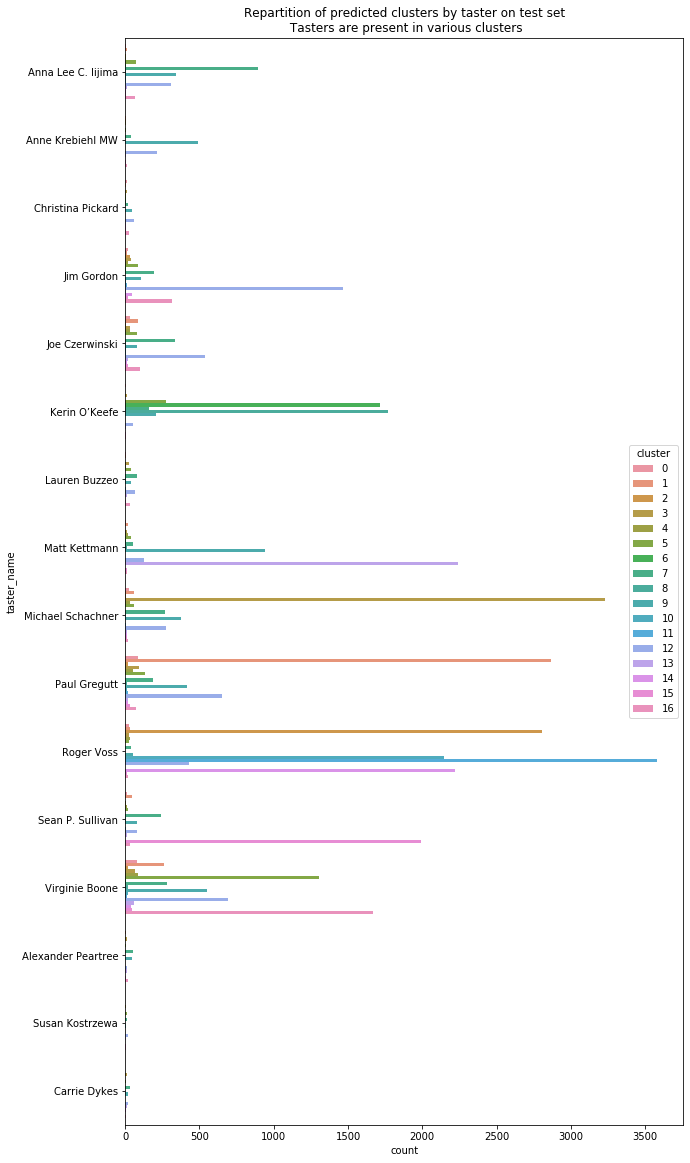

In [124]:
# uncomment this for a barplot of the repartition of the clusters by taster names.
def my_bar_plot_for_clusters(output, variable):
    to_plot = output.groupby(['cluster', variable], as_index=False).title.count()
    if output[variable].nunique() < 10:
        ax = sns.barplot(x=variable, y="title", hue="cluster", data=to_plot)
    else: # switch axis in case of numerous levels
        ax = sns.barplot(x="title", y=variable, hue="cluster", data=to_plot)
    return ax
plt.figure(figsize=(10,20))
ax = my_bar_plot_for_clusters(X_test, 'taster_name')
ax.set_xlabel('count')
ax.set_title('Repartition of predicted clusters by taster on test set\n Tasters are present in various clusters')
plt.show()

## 6. Discussion

We constructed 6 recommender systems:  

1. BoW + cosine similarity
2. tf-idf + cosine similarity
3. tf-idf bigrams + cosine similarity
4. pre-trained word2vec + cosine similarity
5. custom word2vec + cosine similarity
6. LDA topic model + cosine similarity

The fifth (custom word2vec + cosine similarity) is probably not working so well, as asserted by our knowledge of wine.  

All the other are recommending wines that were reviewed by the same taster. We do not know and cannot know the exact reason for this, but this is deeply suspicious: it is very likely that our recommender system is too sensitive about the vocabulary (or style of writing) used by the taster. Even if part of this effect might be explained by the different distribution of province and variety reviewed among the tasters.     

**We do not know if our recommenders find the descriptions to be similar because the wines are similar and thus the descriptions are similar, or because the tasters are similar and thus the descriptions are similar...**

Below we test the recommenders a third time, on another wine, and this time, the authors vary. So the effect is not so strong and is probably a bit diffuse. We do not know any way of solving this question (yet).  

### Final Recommendations on a third wine

In [93]:
# recommendations for the 2nd target wine, index is 90:
target_index = 123

recommended_wines_bow = recommend_top_n_wines(bow_features, target_index=target_index, top_n=5)
recommended_wines_tfidf = recommend_top_n_wines(tfidf_features, target_index=target_index, top_n=5)
recommended_wines_tfidf_bigram = recommend_top_n_wines(tfidf_bigram_features, target_index=target_index, top_n=5)
recommended_wines_pretrained_word2vec = recommend_top_n_wines(pretrained_word2vec_features, 
                                                              target_index=target_index, top_n=5)
recommended_wines_custom_word2vec = recommend_top_n_wines(custom_word2vec_features, 
                                                              target_index=target_index, top_n=5)
recommended_wines_lda = recommend_top_n_wines(vectors_descr_topic, target_index=target_index, top_n=5)

# Our results sofar:
# a collection of each top 5 recommendations for the target 1, wine 14:
recommendations = [recommended_wines_bow, 
                      recommended_wines_tfidf, 
                      recommended_wines_tfidf_bigram, 
                      recommended_wines_pretrained_word2vec, 
                      recommended_wines_custom_word2vec,
                      recommended_wines_lda]
model_names = ['Bow', 'tf-idf unigram', 'tf-idf bigram', 'pretrained word2vec', 'custom word2vec', 'LDA topics']

In [122]:
print_wines_descriptions([123])

['A fairly elegant expression of the variety, this wine is bright in cherry kirsch and pretty aromas of rose petal and lavender, structured to age and enjoy with food. Rector Creek Vineyard is just north of Yountville and planted in rocky alluvial soils. Drink now through 2022.']


In [94]:
# Print metadata of recommended wines:

print("Our target wine:")
print_wines_light([target_index])
print("")

for i, rec in enumerate(recommendations):
    print(model_names[i], 'recommendations (1-5): ')
    for j, wine_index in enumerate(rec):
#         print(str(j+1), ':')
        print_wines_light([wine_index])
    print("")

Our target wine:
['Merlot', 'California', 'Virginie Boone', 91, 'Duckhorn 2012 Rector Creek Vineyard Merlot (Napa Valley)']

Bow recommendations (1-5): 
['Nebbiolo', 'Piedmont', nan, 88, 'Principiano Ferdinando 2004 Serralunga  (Barolo)']
['Sangiovese', 'Washington', 'Sean P. Sullivan', 90, "Almquist 2010 Vintner's Select Spice Cabinet Vineyard Sangiovese (Horse Heaven Hills)"]
['Cabernet Sauvignon', 'Washington', 'Sean P. Sullivan', 90, 'Five Star Cellars 2012 Cabernet Sauvignon (Walla Walla Valley (WA))']
['Nebbiolo', 'Piedmont', 'Kerin O’Keefe', 91, 'Cornarea 2012  Roero']
['Pinot Noir', 'California', 'Virginie Boone', 88, 'Balletto 2012 Winery Block Pinot Noir (Russian River Valley)']

tf-idf unigram recommendations (1-5): 
['Zinfandel', 'California', 'Virginie Boone', 93, 'Robert Biale 2012 Rocky Ridge Vineyard Zinfandel (Rockpile)']
['Sangiovese', 'California', 'Matt Kettmann', 93, 'Cloak & Dagger 2012 Illuminatus Hidden Valley Vineyard Reserve Sangiovese (Paso Robles)']
['Syrah'

### Next Steps for the Project

We should continue the evaluation of the recommendation system, but the only way is probably through collecting customer feedback.  

Eventually, an alternative that we did not try is to assign to each wine its main topic and assess the distribution of the tasters by authors.  

In the meantime, we could make the following assumption: if we are not sure about the recommendation, be conservative, and recommend the wine with the highest rating.  

Buiding the recommender with the recommendations of a unique reviewer, to avoid the difficulties is not useful, as the any final product will have to use recommendations written by several reviewers.

Eventually we could use doc2vec, or another embedding like ELMo, but we learned about them to late in the project. Different similarity measures could have been tried, however using the cosine similarity makes sense.  

Such a recommendation system should maybe limited to one type of wine, for instance only for red wine, white wine, port, champagne. That would limit the possibility of shared vocabulary in wines that are radically different.  

This content-based recommendation system used the vectorized descriptions as features only, as a proof of concept. But any other feature could be added to the recommender, like variety, province, etc. Finding the appropriate weights between the features will be a difficulty.    

The dataset used as input should be updated and completed before launching any product, except eventually if the product is launched in the USA. Eventually one could scrap the website of [Vivino](https://www.vivino.com/)? We are not sure about the legality of it, but they do have the largest wine reviews dataset in the world. 

A feature that could be added, is the possibility to input some keywords (like "dry white wine mineral lemon") and get a recommendation, instead of having to start from an existing wine description.  

#### Potential End Products

If the system is updated, it could be integrated in a wine recommendation app. After the app is launched, we would collect the ratings, evaluate our recommendations. We will then be slowly able to switch to an hybrid recommender by also recommending wines frome users with similar tastes.  

Vivino, the largest wine database does not have any recommendation system yet. They should build one, maybe they find a partner in us ;) !

Another end product that could be built from this project is an interactive online visualization to explore the tastes of the wines. 